# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, Facundo

**Información meteorológica**: Maximiliano Yafusco

## Librerías

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import imblearn as imblearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import (accuracy_score, precision_score, make_scorer, recall_score,f1_score, balanced_accuracy_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import mode
import plotly.graph_objs as go
import plotly.express as px
import joblib
#import optuna

import warnings
warnings.filterwarnings('ignore')



## 1. Análisis descriptivo 

### Observación del Dataset.

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [3]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

El dataset corresponde a los datos meteorológicos de Australia.

En el norte del país el clima es tropical, en el este y oeste el clima es mediterráneo y en el centro es desértico. 

Por este motivo y dado a que la selección de las 10 ciudades es aleatoria, decidimos conservar la información de la variable Location, a través de sus coordenadas (Latitud, Longitud), lo que además generaliza el modelo a otras ubicaciones.

Dartmoor, Victoria: Latitud: -37.9167 Longitud: 141.2833

Nuriootpa, South Australia: Latitud: -34.4700 Longitud: 138.9960

Perth Airport, Western Australia: Latitud: -31.9403 Longitud: 115.9668

Uluru, Northern Territory: Latitud: -25.3444 Longitud: 131.0369

Cobar, New South Wales: Latitud: -31.4983 Longitud: 145.8389

Coffs Harbour, New South Wales: Latitud: -30.2963 Longitud: 153.1157

Walpole, Western Australia: Latitud: -34.9780 Longitud: 116.7330

Cairns, Queensland: Latitud: -16.9203 Longitud: 145.7700

Alice Springs, Northern Territory: Latitud: -23.6980 Longitud: 133.8807

Gold Coast, Queensland: Latitud: -28.0167 Longitud: 153.4000

In [4]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]
#df_weather = df_weather.drop('Location',axis=1)



In [5]:
ciudades_coords = {
    'Dartmoor': {'Latitud': -37.9167, 'Longitud': 141.2833},
    'Nuriootpa': {'Latitud': -34.4700, 'Longitud': 138.9960},
    'PerthAirport': {'Latitud': -31.9403, 'Longitud': 115.9668},
    'Uluru': {'Latitud': -25.3444, 'Longitud': 131.0369},
    'Cobar': {'Latitud': -31.4983, 'Longitud': 145.8389},
    'CoffsHarbour': {'Latitud': -30.2963, 'Longitud': 153.1157},
    'Walpole': {'Latitud': -34.9780, 'Longitud': 116.7330},
    'Cairns': {'Latitud': -16.9203, 'Longitud': 145.7700},
    'AliceSprings': {'Latitud': -23.6980, 'Longitud': 133.8807},
    'GoldCoast': {'Latitud': -28.0167, 'Longitud': 153.4000}
}

df_weather['Latitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Latitud'])
df_weather['Longitude'] = df_weather['Location'].map(lambda loc: ciudades_coords[loc]['Longitud'])
df_weather = df_weather.drop('Location',axis=1)

In [6]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [7]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [8]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)    

In [9]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28234 entries, 6049 to 145458
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           28234 non-null  datetime64[ns]
 1   MinTemp        28193 non-null  float64       
 2   MaxTemp        28211 non-null  float64       
 3   Rainfall       28049 non-null  float64       
 4   Evaporation    18330 non-null  float64       
 5   Sunshine       15473 non-null  float64       
 6   WindGustDir    27545 non-null  object        
 7   WindGustSpeed  27591 non-null  float64       
 8   WindDir9am     26591 non-null  object        
 9   WindDir3pm     27770 non-null  object        
 10  WindSpeed9am   27878 non-null  float64       
 11  WindSpeed3pm   27886 non-null  float64       
 12  Humidity9am    27887 non-null  float64       
 13  Humidity3pm    27881 non-null  float64       
 14  Pressure9am    27926 non-null  float64       
 15  Pressure3pm    27926

In [10]:
df_weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,Month
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,1004.4,2.0,5.0,26.6,33.4,No,No,-31.4983,145.8389,ene
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,1012.1,1.0,1.0,20.3,27.0,No,No,-31.4983,145.8389,ene
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,1011.6,NaN,1.0,NaN,32.7,No,No,-31.4983,145.8389,ene
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,1009.2,1.0,6.0,28.7,34.9,No,No,-31.4983,145.8389,ene
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,1009.1,1.0,5.0,29.1,35.6,No,No,-31.4983,145.8389,ene


### División del DataSet: Train - Test

In [11]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 24), (5647, 24), (22587,), (5647,))

In [12]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [13]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [14]:
X_train.shape

(22253, 24)

In [15]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Latitude,Longitude
count,22253,22228.0,22236.0,22159.0,14656.0,12411.0,22032.0,22223.0,22223.0,22014.0,22009.0,22208.0,22208.0,13224.0,12828.0,22246.0,22241.0,22253.0,22253.0
mean,2013-05-01 00:43:13.591875072,13.6,25.0,2.6,5.8,8.0,40.1,15.3,19.5,63.6,49.4,1017.5,1014.9,3.9,4.0,19.1,23.5,-29.7,137.9
min,2008-12-01 00:00:00,-5.2,7.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,982.0,985.1,0.0,0.0,-0.3,5.3,-37.9,116.0
25%,2011-02-13 00:00:00,8.8,19.8,0.0,2.8,5.3,31.0,9.0,13.0,50.0,30.0,1013.0,1010.3,1.0,1.0,13.9,18.4,-34.5,131.0
50%,2013-06-26 00:00:00,13.4,24.9,0.0,5.0,9.0,39.0,15.0,19.0,65.0,52.0,1017.4,1014.8,4.0,4.0,19.0,23.2,-31.5,141.3
75%,2015-07-04 00:00:00,18.8,29.9,0.8,8.0,10.9,46.0,20.0,24.0,80.0,66.0,1021.9,1019.3,7.0,7.0,24.2,28.1,-25.3,145.8
max,2017-06-25 00:00:00,31.0,46.6,371.0,86.2,14.3,113.0,72.0,61.0,100.0,100.0,1040.4,1037.7,8.0,8.0,39.4,45.2,-16.9,153.4
std,NaN,6.4,6.9,10.3,4.3,3.7,11.9,8.2,8.2,22.1,23.1,6.6,6.6,2.9,2.8,6.6,6.8,6.0,12.8


In [16]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         41.0
Evaporation      34.0
WindDir9am        5.0
Humidity3pm       1.0
Humidity9am       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
RainToday         0.0
Rainfall          0.0
Pressure3pm       0.0
Pressure9am       0.0
WindSpeed9am      0.0
WindSpeed3pm      0.0
MinTemp           0.0
MaxTemp           0.0
Temp3pm           0.0
Temp9am           0.0
Date              0.0
Latitude          0.0
Longitude         0.0
Month             0.0
dtype: float64

In [17]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Latitude
Longitude
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [18]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

In [19]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         18.18
WindGustSpeed     2.64
Evaporation       1.88
WindSpeed3pm      1.52
WindSpeed9am      1.12
Pressure9am       0.79
Pressure3pm       0.59
Humidity9am       0.10
Temp3pm           0.05
MaxTemp           0.01
MinTemp           0.00
Sunshine          0.00
Humidity3pm       0.00
Cloud9am          0.00
Cloud3pm          0.00
Temp9am           0.00
Latitude          0.00
Longitude         0.00
dtype: float64

### Visualización de datos: boxplots, histogramas y scatter plots

In [20]:
def visualizar_features_cuanti_sin_lluvia(tipo_grafico: str) -> None:
    # A la feature lluvia Rainfall se le aplicará un análisis particular
    features_cuanti_sin_lluvia = features_cuanti.copy()
    features_cuanti_sin_lluvia.remove('Rainfall')
    n_features_cuanti_sin_lluvia = len(features_cuanti_sin_lluvia)
    n_col = 3
    n_row = n_features_cuanti_sin_lluvia // n_col if n_features_cuanti_sin_lluvia % n_col == 0 else n_features_cuanti_sin_lluvia // n_col + 1
    fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col * 5, 5 * n_row))
    titulo = 'Boxplots de las variables predictoras cuantitativas según valor de la variable target' if tipo_grafico == 'boxplots' else "Histogramas de variables cuantitativas"
    fig.suptitle(titulo, fontsize=16)
    fig.subplots_adjust(hspace=0.2)

    # Definir la paleta de colores para 'Yes' y 'No'
    palette = {'Yes': 'darkorange', 'No': 'lightblue'}

    for i, feature in enumerate(features_cuanti_sin_lluvia):
        # Posición de cada gráfico 
        row = i // n_col
        col = i % n_col
        
        if tipo_grafico == 'boxplots':
            sns.boxplot(data=X_train, x=y_train, y=feature, ax=axes[row, col], palette=palette)
        else:
            sns.histplot(df_train[feature],ax=axes[row, col])  
                # Eliminar subplots vacíos si es necesario
    if n_features_cuanti_sin_lluvia % n_col != 0:
        for i in range(n_features_cuanti_sin_lluvia % n_col, n_col):
            fig.delaxes(axes[n_row - 1, i])

    plt.show()


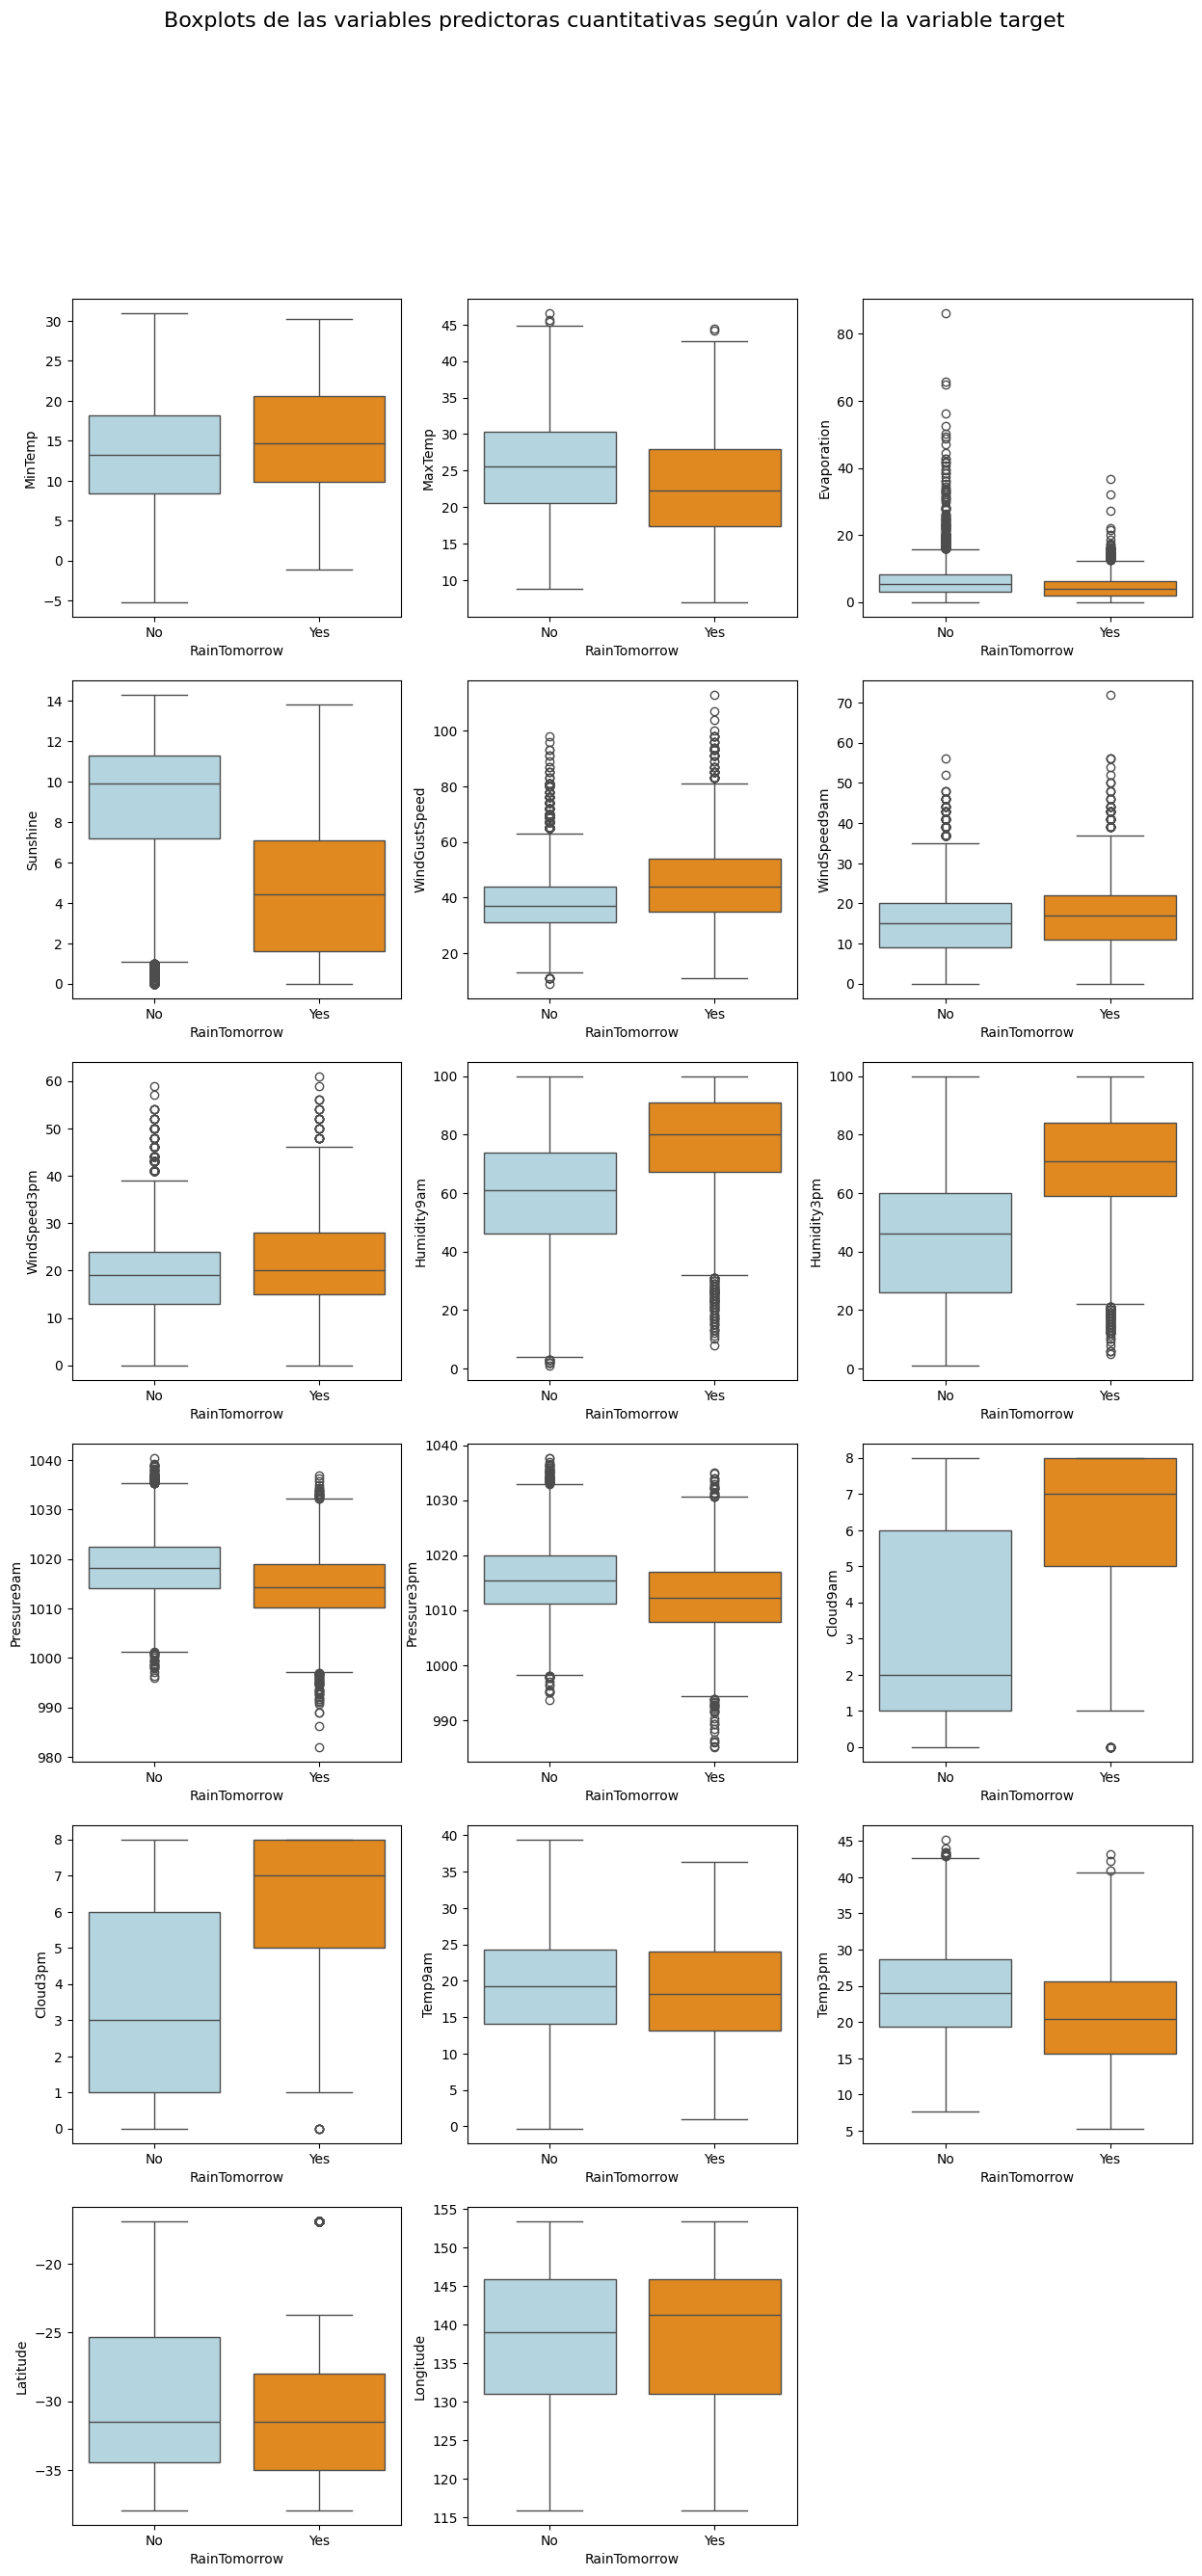

In [21]:
# A la función puede recibir el string boxplots, caso contrario grafica histogramas
visualizar_features_cuanti_sin_lluvia('boxplots')

Se observa que cuando la humedad es mayor al 60% es altamente probable que llueva, pues, cuando no llovió, solamente en el 25% de los casos la humedad presentó un valor mayor a ése, en cambio. Cuando sí llovió, en el 75% de los casos, el valor superó dicha referencia. Esto se informa a modo de justificación acerca de la elección de esta variable para construir el modelo ingenuo solicitado en el punto 3 del TP.

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (sunshine | cloud 9 am | cloud 3 pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad. 

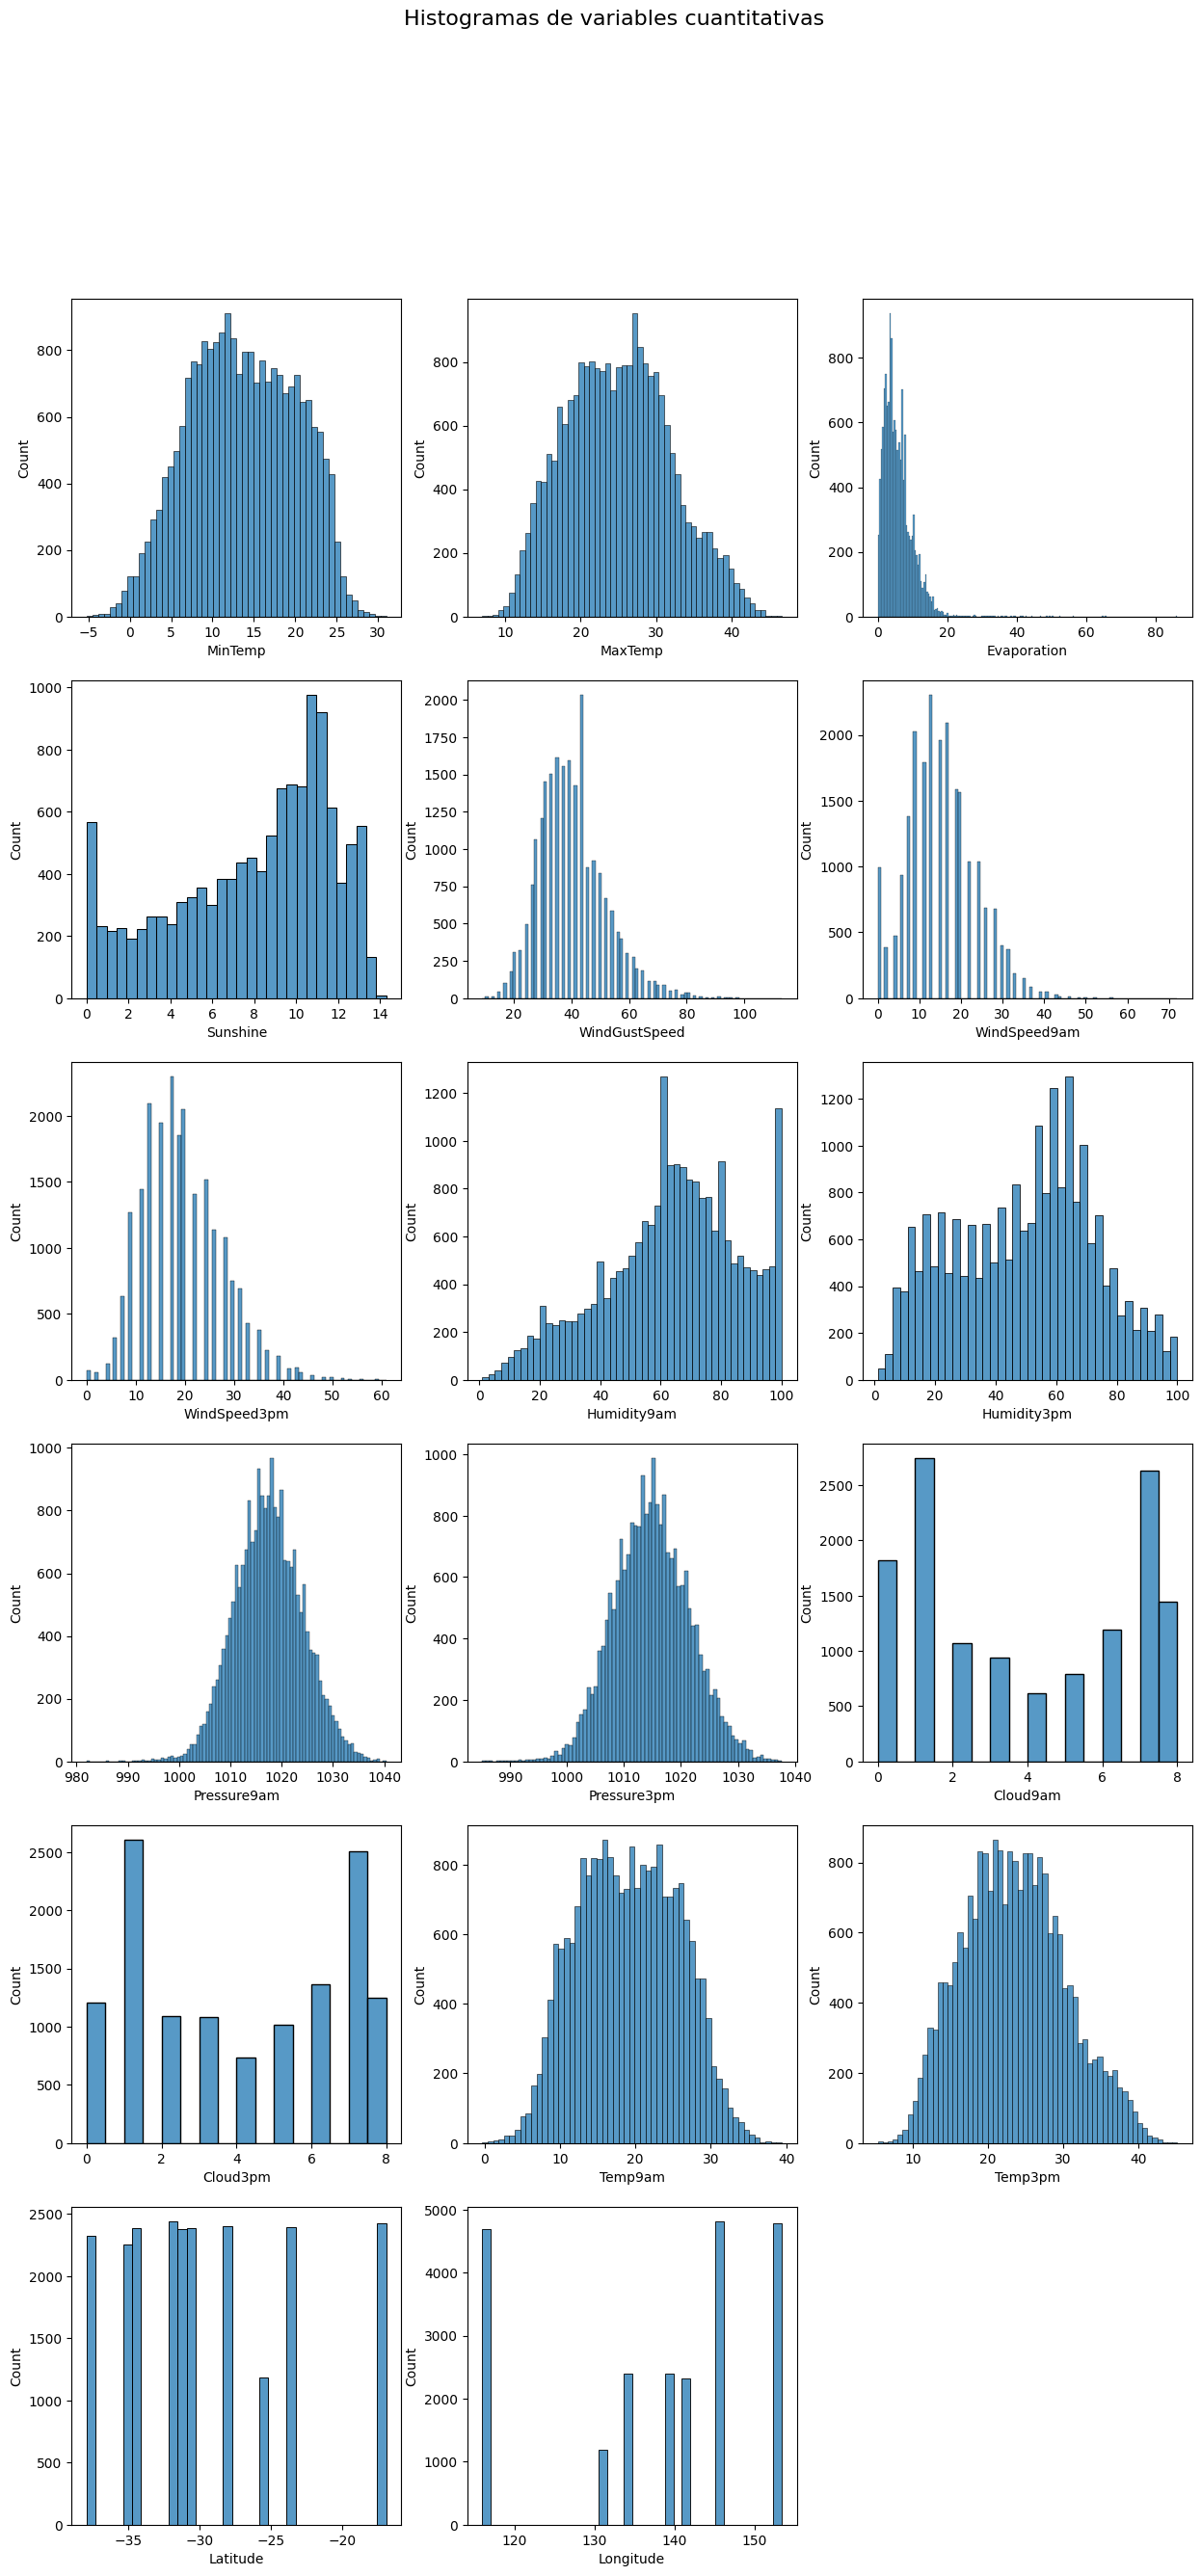

In [22]:
visualizar_features_cuanti_sin_lluvia('histogramas')

El análisis de los histogramas serán tenidos en cuenta para la imputación de faltantes.
Se observa que las siguientes features son 
* simétricas:
Temperatura (en todas sus versiones)
* asimétricas:
Evaporación | Viento (en todas sus versiones) | Humedad (en todas sus versiones) | Presión (en todas sus versiones)
* bimodales:
Nubosidad (en todas sus versiones) | Radiación Solar

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

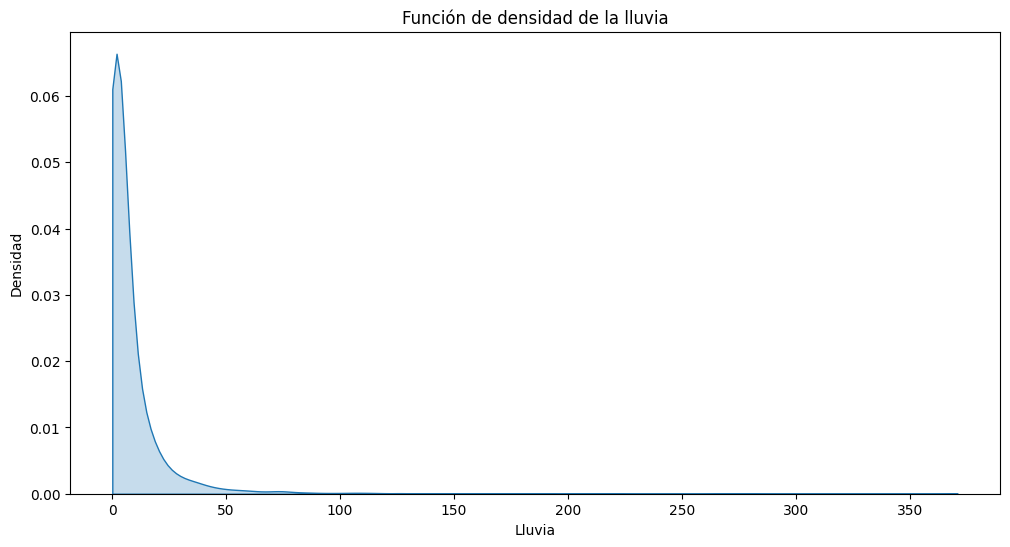

In [23]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [24]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),4)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

,Frecuencia_absoluta,Frecuencia_relativa,Frecuencia_absoluta_acumulada,Frecuencia_relativa_acumulada
Rainfall,,,,
"(0, 50]",7467,0.9780,7467,0.9780
"(50, 100]",119,0.0156,7586,0.9936
"(100, 150]",32,0.0042,7618,0.9978
"(150, 200]",11,0.0014,7629,0.9992
"(200, 250]",3,0.0004,7632,0.9996
"(250, 300]",2,0.0003,7634,0.9999
"(300, 350]",0,0.0000,7634,0.9999
"(350, 400]",1,0.0001,7635,1.0000


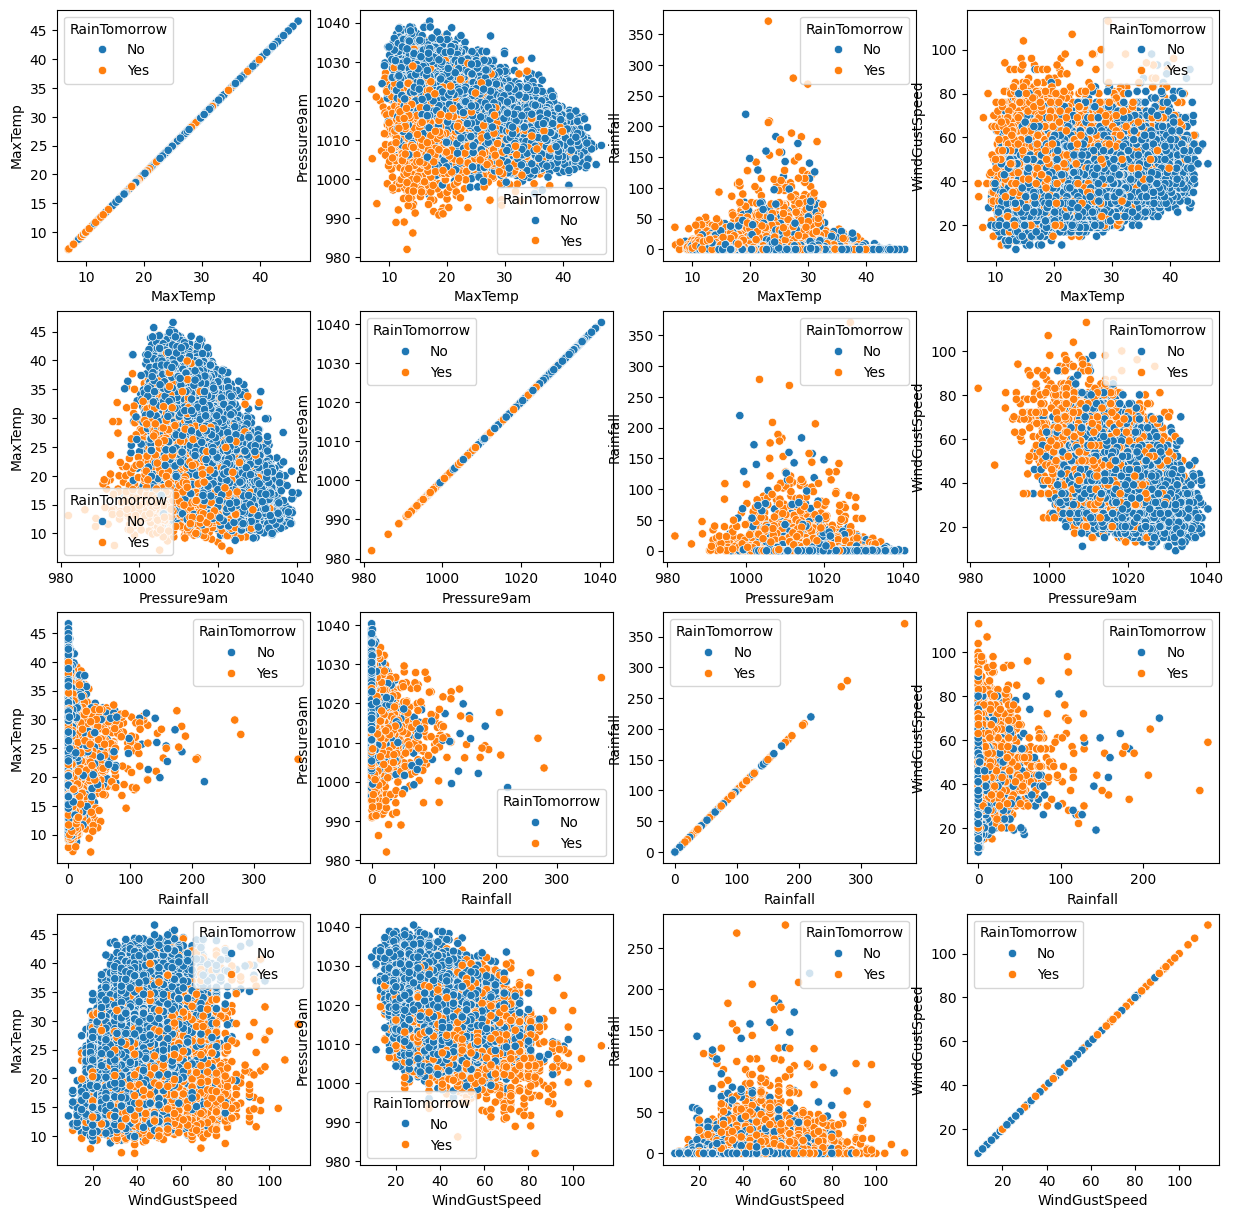

In [25]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
columns = ['MaxTemp','Pressure9am','Rainfall','WindGustSpeed']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

Se observa a partir de estos gráficos de dispersión la posibilidad de trazar fácilmente una recta frontera en las gráficas, por ejemplo, pressure9am vs máxima temperatura, windgustspeed vs pressure9am y windgustspeed vs máxima temperatura para determinar la pertenencia a una clase de la target. Al contrario, la feature rainfall no sirve para junta a otra feature poder trazar una recta frontera.

In [26]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

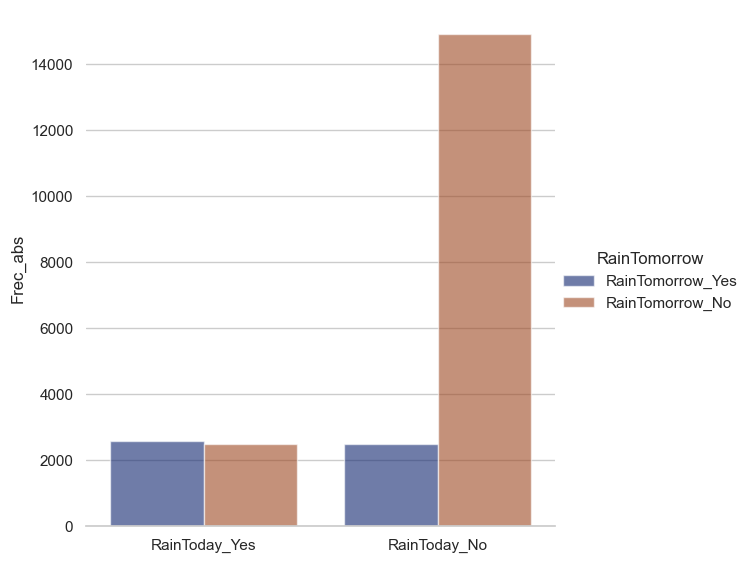

In [27]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

Se puede observar la correlación que existe entre raintoday y raintomorrow, si hoy llueve es más probable que mañana también llueva, en cambio, si hoy no llueve, es altamente probable que mañana no llueva. 

### Matriz de correlación de variables

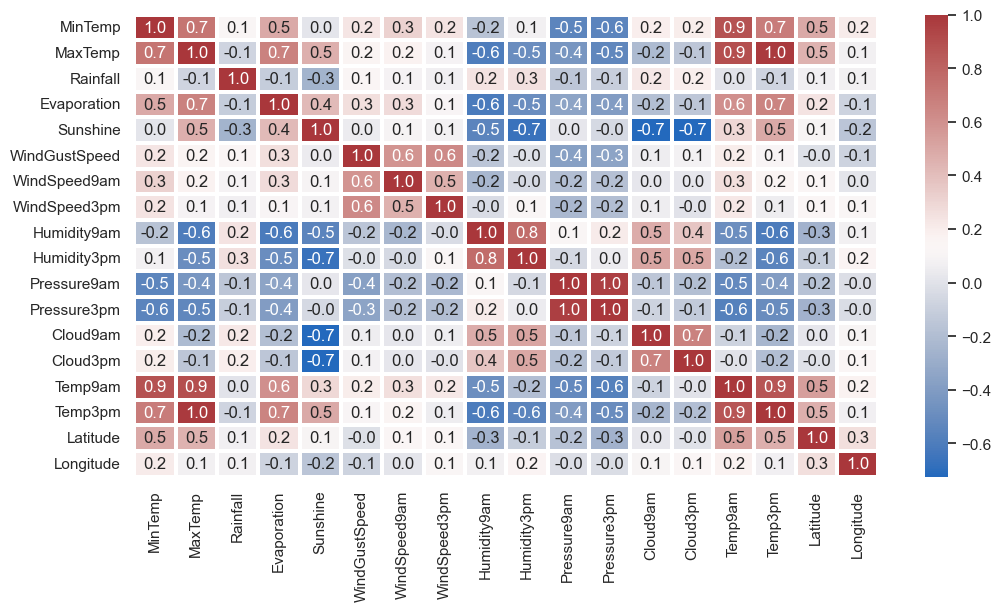

In [28]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un rango entre las features. Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas. Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature sunshine y las features vinculadas con la medición de la nubosidad.

### Análisis de balanceo del dataset 

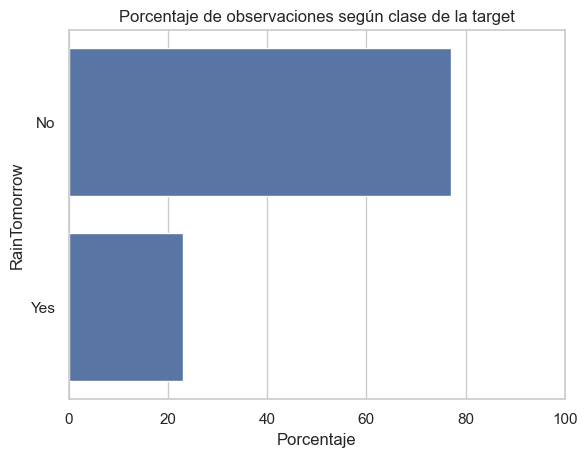

In [29]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

Clase Raintomorrow = no --> Clase negativa (mayoritaria)

Clase Raintomorrow = si --> Clase positiva (minoritaria)

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa. Es importante este análisis porque al estar desbalanceado corresponde aplicar las técnicas de oversampling, undersampling o discriminación de penalidad asignada a cada clase para evitar que modelo tienda a predecir la categoría mayoritaria.  

### Análisis y decisión sobre datos faltantes y atípicos

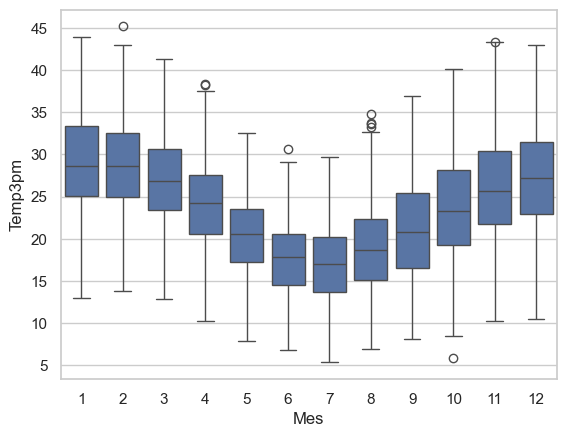

In [30]:
# Se analiza el caso de features que presentan un significativo comportamiento estacional
# y por ende puede que se justifique imputar faltantes aplicando un estadístico segmentado por mes
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

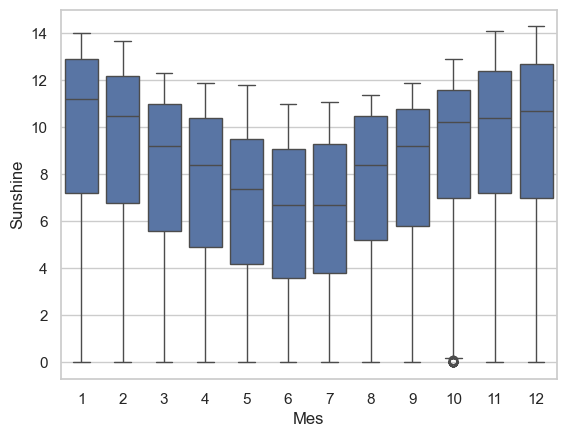

In [31]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

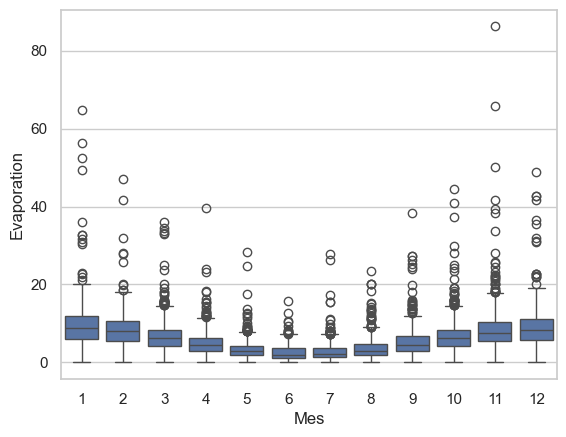

In [32]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

In [33]:
X_train.isna().sum()

Date                0
MinTemp            25
MaxTemp            17
Rainfall           94
Evaporation      7597
Sunshine         9842
WindGustDir       233
WindGustSpeed     221
WindDir9am       1020
WindDir3pm        100
WindSpeed9am       30
WindSpeed3pm       30
Humidity9am       239
Humidity3pm       244
Pressure9am        45
Pressure3pm        45
Cloud9am         9029
Cloud3pm         9425
Temp9am             7
Temp3pm            12
RainToday          94
Latitude            0
Longitude           0
Month               0
dtype: int64

Decidimos el criterio para la imputación de las direcciones de vientos faltantes, basados en la consulta con un meteorólogo.

En la práctica, si falta la información de uno de los vientos, se completa el valor de alguno de los otros vientos del mismo día.
Esto no provoca fuga de datos porque es el procedimiento habitual en tiempo real.

Si faltan los valores de los 3 campos de direcciones de vientos, se imputan por la moda calculada en el conjunto de entrenamiento.

No se procede de igual manera para otras variables, por ejemplo, no se imputan los valores faltantes de la temperatura de las 9am con las de las 3pm debido al rango variación de sus valores. 

En estos casos, es preferible imputar por el promedio de los días próximos. En nuestro caso, imputamos por el promedio mensual o por la mediana, dependiendo del comportamiento de cada variable.

In [34]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
# que justifican imputar por media segmentada
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [35]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

Función para imputar valores en las columnas de dirección del viento
def impute_wind_directions(row):
    if pd.notna(row['WindGustDir']):
        # Si WindGustDir no es nulo, imputar WindDir9am y WindDir3pm con ese valor
        if pd.isna(row['WindDir9am']):
            row['WindDir9am'] = row['WindGustDir']
        if pd.isna(row['WindDir3pm']):
            row['WindDir3pm'] = row['WindGustDir']
    else:
        # Si WindGustDir es nulo, imputar con los valores entre WindDir9am y WindDir3pm
        if pd.notna(row['WindDir9am']):
            row['WindGustDir'] = row['WindDir9am']
            if pd.isna(row['WindDir3pm']):
                row['WindDir3pm'] = row['WindDir9am']
        elif pd.notna(row['WindDir3pm']):
            row['WindGustDir'] = row['WindDir3pm']
            if pd.isna(row['WindDir9am']):
                row['WindDir9am'] = row['WindDir3pm']
    return row

Aplicar la función a los DataFrames
X_train_imputed = X_train_imputed.apply(impute_wind_directions, axis=1)
X_test_imputed = X_test_imputed.apply(impute_wind_directions, axis=1)

In [36]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direction_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
for feature_cuali in features_cuali[:3]:
    X_train_imputed[feature_cuali] = X_train_imputed[feature_cuali].map(direction_dict)
    X_test_imputed[feature_cuali] = X_test_imputed[feature_cuali].map(direction_dict)
X_train_imputed.loc[0]

Date             2016-06-01 00:00:00
MinTemp                         11.9
MaxTemp                         23.2
Rainfall                         0.0
Evaporation                      2.6
Sunshine                    6.147587
WindGustDir                        E
WindGustSpeed                   30.0
WindDir9am                         E
WindDir3pm                         E
WindSpeed9am                     7.0
WindSpeed3pm                    19.0
Humidity9am                     77.0
Humidity3pm                     61.0
Pressure9am                   1020.9
Pressure3pm                   1018.4
Cloud9am                    4.303057
Cloud3pm                    4.351699
Temp9am                         17.4
Temp3pm                         22.4
RainToday                         No
Latitude                     -23.698
Longitude                   133.8807
Month                            jun
Name: 0, dtype: object

In [37]:
# Tratamiento de faltantes en features asimétricas que justican imputar por mediana simple
X_train_mediana_WindGustSpeed = X_train['WindGustSpeed'].median()
X_train_mediana_Humidity9am = X_train['Humidity9am'].median()
X_train_mediana_Humidity3pm = X_train['Humidity3pm'].median()
X_train_mediana_Rainfall = X_train['Rainfall'].median()
X_train_mediana_WindSpeed9am = X_train['WindSpeed9am'].median()
X_train_mediana_WindSpeed3pm = X_train['WindSpeed3pm'].median()
X_train_mediana_Pressure9am  = X_train['Pressure9am'].median()
X_train_mediana_Pressure3pm = X_train['Pressure3pm'].median()

X_train_imputed = X_train_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustSpeed': X_train_mediana_WindGustSpeed,
    'Humidity9am': X_train_mediana_Humidity9am,
    'Humidity3pm': X_train_mediana_Humidity3pm,
    'Rainfall': X_train_mediana_Rainfall,
    'WindSpeed9am': X_train_mediana_WindSpeed9am,
    'WindSpeed3pm': X_train_mediana_WindSpeed3pm,
    'Pressure9am': X_train_mediana_Pressure9am,
    'Pressure3pm': X_train_mediana_Pressure3pm,
})

In [38]:
# Tratamiento de faltantes en features simétricas que justican imputar por media simple
X_train_mean_MinTemp = X_train['MinTemp'].mean()
X_train_mean_MaxTemp = X_train['MaxTemp'].mean()
X_train_mean_Temp9am = X_train['Temp9am'].mean()
X_train_mean_Temp3pm = X_train['Temp3pm'].mean()


X_train_imputed = X_train_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})
X_test_imputed = X_test_imputed.fillna({
    'MinTemp': X_train_mean_MinTemp,
    'MaxTemp': X_train_mean_MaxTemp,
    'Temp9am': X_train_mean_Temp9am,
    'Temp3pm': X_train_mean_Temp3pm,
})

In [39]:
X_train_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [40]:
X_test_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Latitude         0
Longitude        0
Month            0
dtype: int64

In [41]:
# Tratamiento de valores atípicos para la feature Rainfall
# La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los 
# parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado 
# para la variable en cuestión.
s_lluvia = X_train_imputed[X_train_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_imputed_idx_lluvia_ati = X_train_imputed[X_train_imputed['Rainfall']>valor_tipico_sup].index
X_train_imputed.loc[X_train_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_imputed[X_test_imputed['Rainfall']>valor_tipico_sup].index
X_test_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup

### Codificación de variables categóricas

In [42]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False,drop='first')
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [43]:
def codificar_target(serie:pd.Series):
    """Recibe una serie para cambiar el nombre y a su vez mapear 
    sus valores para codificarlos"""
    serie.name ='RainTomorrow_Yes'
    serie_codificada =  serie.map({"No":0,"Yes":1})
    return serie_codificada

In [44]:
#Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [45]:
X_train_encoded_imputed.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Latitude         0
Longitude        0
WindGustDir_N    0
WindGustDir_S    0
WindGustDir_W    0
WindDir9am_N     0
WindDir9am_S     0
WindDir9am_W     0
WindDir3pm_N     0
WindDir3pm_S     0
WindDir3pm_W     0
RainToday_Yes    0
Month_ago        0
Month_dic        0
Month_ene        0
Month_feb        0
Month_jul        0
Month_jun        0
Month_mar        0
Month_may        0
Month_nov        0
Month_oct        0
Month_sep        0
dtype: int64

In [46]:
#Codificación de la target 
y_train_encoded = codificar_target(y_train)
y_test_encoded = codificar_target(y_test)
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

In [47]:
X_train_encoded_imputed.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')

In [48]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.147587           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.965803           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  Pressure9am  Pressure3pm  \
0           30.0          E          E  ...       1020.9       1018.4   
1           41.0          S          W  ...       1025.8       1022.8   
2           41.0          N          W  ...       1010.9       1008.1   
3           33.0          E          S  ...       1017.4       1014.8   
4           39.0          E          S  ...       1018.2       1014.8   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  Latitude  L

### Escalado de datos 

In [49]:
# Escalado de datos - NO SE ESCALAN VARIABLES CUALITATIVAS
scaler = StandardScaler()
X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)


In [50]:
# Primero se filtra para eliminar las cuantitativas no escaladas para luego unir 
# las cualitativas con las cuantitativas sí escaladas
X_train_encoded_imputed_cuali = X_train_encoded_imputed.drop(features_cuanti,axis=1)
X_train_encoded_imputed_cuantiscaled_cuali = pd.concat([X_train_encoded_imputed_scaled,X_train_encoded_imputed_cuali],axis=1)

X_test_encoded_imputed_cuali = X_test_encoded_imputed.drop(features_cuanti,axis=1)
X_test_encoded_imputed_cuantiscaled_cuali = pd.concat([X_test_encoded_imputed_scaled,X_test_encoded_imputed_cuali],axis=1)

In [51]:
X_train_encoded_imputed_cuantiscaled_cuali 
y_test_encoded
X_test_encoded_imputed_cuantiscaled_cuali 
y_test_encoded

0       0
1       0
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: RainTomorrow_Yes, Length: 5647, dtype: int64

## 2. Regresión Logística

Implementamos distintos modelos a los fines de poder comparar las distintas técnicas de optimización:

1 - Modelo de Regresión Logistica Básico.

2- Modelo de Regresión Logistica Balanceado.

3- Modelo de Regresión Logistica Balanceado con Regularización Lasso.

4- Predicciones finales usando los umbrales óptimos.


In [52]:
#Observo columnas de X_train_encoded_imputed_cuantiscaled_cuali
print(X_train_encoded_imputed_cuantiscaled_cuali.columns)
print("Cant. de columnas: ", len(X_train_encoded_imputed_cuantiscaled_cuali.columns))

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Latitude', 'Longitude', 'Date', 'WindGustDir_N',
       'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'RainToday_Yes', 'Month_ago', 'Month_dic', 'Month_ene', 'Month_feb',
       'Month_jul', 'Month_jun', 'Month_mar', 'Month_may', 'Month_nov',
       'Month_oct', 'Month_sep'],
      dtype='object')
Cant. de columnas:  40


In [53]:
# Eliminar la columna 'Date' de los conjuntos ( nos quedamos con los meses)
x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

# No es necesario modificar y_train y y_test
y_train_clean = y_train_encoded
y_test_clean = y_test_encoded

In [54]:
# Mostrar las dimensiones de X_train_clean
print("Dimensiones de X_train_clean:", x_train_clean.shape)
print("Dimensiones de y_train_clean:", y_train_clean.shape)   # Mostrar las dimensiones de y_train_clean
print("Dimensiones de X_test_clean:", x_test_clean.shape)
print("Dimensiones de y_test_clean:", y_test_clean.shape)


Dimensiones de X_train_clean: (22253, 39)
Dimensiones de y_train_clean: (22253,)
Dimensiones de X_test_clean: (5647, 39)
Dimensiones de y_test_clean: (5647,)


### Regresión Logistica Base (Sin balancear)

In [55]:
# Entrenamos Regresion Logistica básica sin ajustar parametros.
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(x_train_clean, y_train_clean)
y_pred = logistic_model.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred))
print(confusion_matrix(y_test_clean, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4373
           1       0.76      0.56      0.65      1274

    accuracy                           0.86      5647
   macro avg       0.82      0.76      0.78      5647
weighted avg       0.85      0.86      0.85      5647

[[4142  231]
 [ 556  718]]


$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$


In [56]:
# Calcular Balanced Accuracy
balanced_acc_rl = balanced_accuracy_score(y_test_clean, y_pred)
print(f'Balanced Accuracy Reg. Logistica Base: {balanced_acc_rl:.2f}')

Balanced Accuracy Reg. Logistica Base: 0.76


In [57]:
cf_matrix = confusion_matrix(y_test_clean, y_pred)

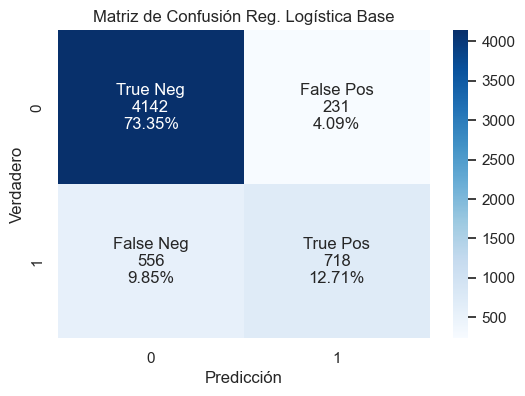

In [58]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Ajustar el tamaño de la figura
plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Base', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

Análisis de matriz de confusión:

TN = 4142 Casos donde no llueve y predice que no llueve.

FP = 231 Casos donde no llueve pero predice que llueve.

FN = 556 Casos donde llueve pero predice que no llueve.

TP = 718 Casos donde llueve y predice que llueve correctamente.

##### Curva ROC y AUC 

In [59]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reglog= logistic_model.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test_clean, y_probs_reglog)
roc_auc_rl = auc(fpr_rl, tpr_rl)

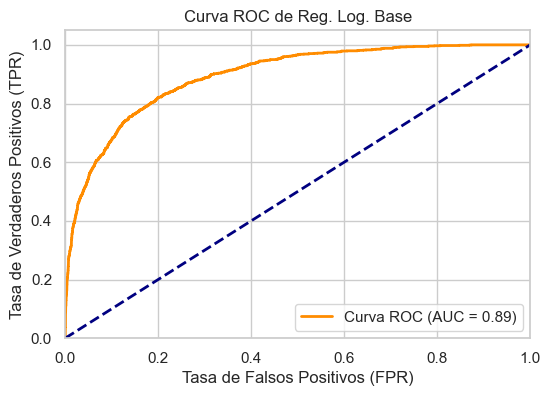

In [60]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_rl, tpr_rl, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Base')
plt.legend(loc="lower right")
plt.show()

### Regresión Logística Balanceada.

Class_weight = 'balanced' le asigna pesos distintos en el cálculo de costo para cada clase. En este caso, como la relación de datos es aprox. 77% (clase 0) / 23% (clase minoritaria 1) , el peso para la clase "1" será aproximadamente 3.35 veces mayor que el peso para la clase "0" (penaliza aprox. 3,35 veces más a la clase minoritaria que el de la clase mayoritaria.)

In [61]:
logistic_model_balanced = LogisticRegression(random_state=42, class_weight= "balanced")
logistic_model_balanced.fit(x_train_clean, y_train_clean)
y_pred_balanced = logistic_model_balanced.predict(x_test_clean)

print("Resultados con regresión logística\n")
print(classification_report(y_test_clean, y_pred_balanced))
print(confusion_matrix(y_test_clean, y_pred_balanced))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.65      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

[[3523  850]
 [ 242 1032]]


In [62]:
# Calcular Balanced Accuracy
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_balanced)

print(f'Balanced Accuracy Reg. Logistica Balanceada: {balanced_acc_balanced:.2f}')

Balanced Accuracy Reg. Logistica Balanceada: 0.81


In [63]:
cf_matrix_b = confusion_matrix(y_test_clean, y_pred_balanced)

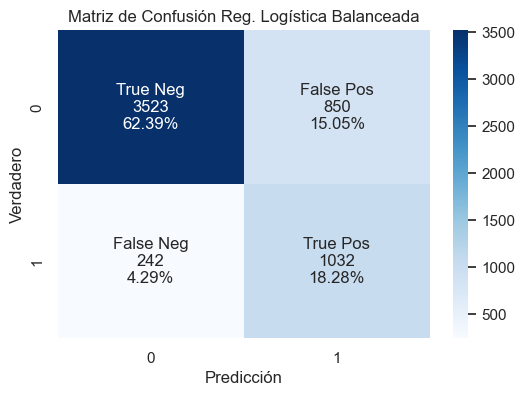

In [64]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_b.flatten()/np.sum(cf_matrix_b)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_b, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [65]:
# Obtengo las probabilidades de predicción del modelo
y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_ba, tpr_ba, thresholds_ba = roc_curve(y_test_clean, y_probs_balanced)
roc_auc = auc(fpr_ba, tpr_ba)

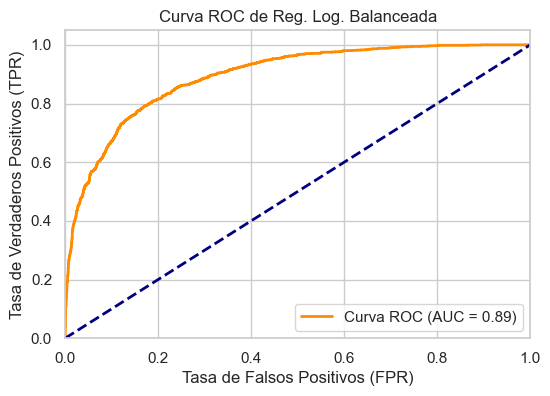

In [66]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_ba, tpr_ba, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada')
plt.legend(loc="lower right")
plt.show()

### Regresión Log. Balanceada con Regularización

In [67]:
# Crear un modelo de regresión logística con regularización L1 (Lasso)
# Ajusta el valor de 'C' para controlar la fuerza de la regularización (menos es más regularización)
# Un valor más pequeño de 'C' aumentará la regularización

logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=0.5, solver='saga',random_state=42, class_weight= "balanced")
#logistic_model_balanced_regul = LogisticRegression(penalty='l1', C=1.5, solver='saga',random_state=42, class_weight= "balanced")

# Entrenar el modelo con tus datos de entrenamiento
logistic_model_balanced_regul.fit(x_train_clean, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_pred_reg = logistic_model_balanced_regul.predict(x_test_clean)

In [68]:
# Generar un informe de clasificación
reporte_clasificacion = classification_report(y_test_clean, y_pred_reg)
print("Informe de Clasificación:")
print(reporte_clasificacion)

# Calcular la matriz de confusión
matriz_confusion_regularizacion = confusion_matrix(y_test_clean, y_pred_reg)
print("Matriz de Confusión:")
print(matriz_confusion_regularizacion)

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.55      0.81      0.66      1274

    accuracy                           0.81      5647
   macro avg       0.74      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

Matriz de Confusión:
[[3527  846]
 [ 241 1033]]


In [69]:
# Calcular Balanced Accuracy
balanced_acc_reg= balanced_accuracy_score(y_test_clean, y_pred_reg)

print(f'Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: {balanced_acc_reg:.2f}')

Balanced Accuracy Reg. Logistica Balanceada Regularizacíón: 0.81


In [70]:
cf_matrix_reg = confusion_matrix(y_test_clean, y_pred_reg)

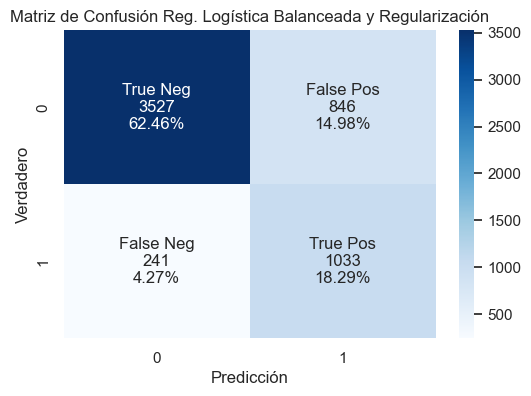

In [71]:
# Matriz de confusión con Heatmap.
labels = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_reg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_reg.flatten()/np.sum(cf_matrix_reg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(6, 4))  
sns.heatmap(cf_matrix_reg, annot=labels, fmt="", cmap='Blues')

plt.title('Matriz de Confusión Reg. Logística Balanceada y Regularización', fontsize=12)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##### Curva ROC y AUC 

In [72]:
# Obtengo las probabilidades de predicción del modelo
y_probs_reg= logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]  # probabilidades

# Calculo la ROC y el AUC
fpr_re, tpr_re, thresholds_re = roc_curve(y_test_clean, y_probs_reg)
roc_auc_re = auc(fpr_re, tpr_re)

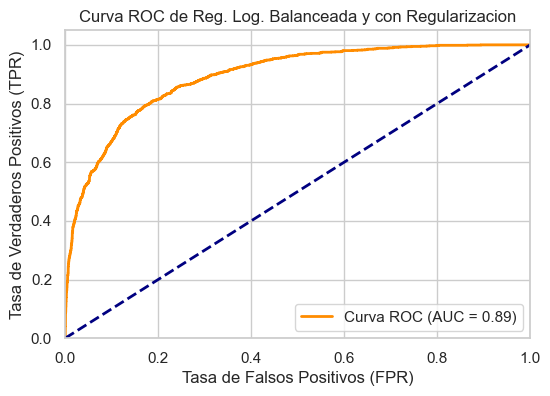

In [73]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_re, tpr_re, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc_re)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC de Reg. Log. Balanceada y con Regularizacion')
plt.legend(loc="lower right")
plt.show()

## 3. Modelos Base (Ingenuos) 

### Modelo Base Naive Bayes.

El clasificador Naive Bayes se considera "ingenuo" debido a la suposición simplificada que hace sobre la independencia de las características. GaussianNB: para características numéricas continuas (como temperatura, humedad, etc.) que pueden seguir una distribución normal.

In [74]:
from sklearn.naive_bayes import GaussianNB

# Crear el clasificador Naive Bayes
naive_bayes_model = GaussianNB()

# Entrenar el modelo
naive_bayes_model.fit(x_train_clean, y_train_clean)

# Hacer predicciones en el conjunto de prueba
y_pred_nb = naive_bayes_model.predict(x_test_clean)


In [75]:
# Mostrar el reporte de clasificación
print("Resultados de Naive Bayes:\n")
print(classification_report(y_test_clean, y_pred_nb))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_nb))
cf_matrix_nb= confusion_matrix(y_test_clean, y_pred_nb)


Resultados de Naive Bayes:

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4373
           1       0.56      0.69      0.62      1274

    accuracy                           0.81      5647
   macro avg       0.73      0.77      0.74      5647
weighted avg       0.83      0.81      0.81      5647

Matriz de Confusión:

[[3691  682]
 [ 400  874]]


In [76]:
# Calcular Balanced Accuracy
balanced_acc_nv= balanced_accuracy_score(y_test_clean, y_pred_nb)

print(f'Balanced Accuracy Naive Bayes: {balanced_acc_nv:.2f}')

Balanced Accuracy Naive Bayes: 0.77


In [77]:
# Obtengo las probabilidades de predicción del modelo
y_probs_nb = naive_bayes_model.predict_proba(x_test_clean)[:, 1]

# Calculo la ROC y el AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_clean, y_probs_nb)
roc_auc = auc(fpr_nb, tpr_nb)

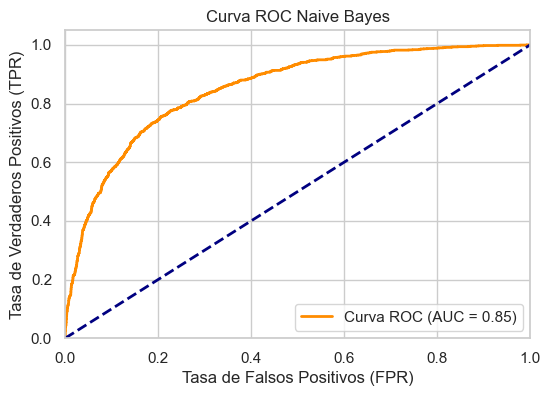

In [78]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Modelo Base: Basado en valor de variable Humedad (Humidity3pm).

In [79]:
media = X_test['Humidity3pm'].mean()
std = X_test['Humidity3pm'].std()
valor_60_escalado = (60-media) / std
valor_60_escalado

np.float64(0.4534371929497258)

In [80]:
direction_dict = {
    True:1,
    False:0,
}
y_pred_humidity = x_test_clean['Humidity3pm']>valor_60_escalado
y_pred_humidity = y_pred_humidity.map(direction_dict)
y_pred_humidity

0       0
1       1
2       1
3       0
4       0
       ..
5642    0
5643    0
5644    0
5645    0
5646    1
Name: Humidity3pm, Length: 5647, dtype: int64

In [81]:
y_pred_humidity.value_counts()

Humidity3pm
0    3562
1    2085
Name: count, dtype: int64

In [82]:
# Predecir usando la Humedad de las 3pm
# Calcular la precisión
accuracy_humidity = accuracy_score(y_test_clean, y_pred_humidity)
print(f"Accuracy del modelo por Humidity: {accuracy_humidity:.2f}")

Accuracy del modelo por Humidity: 0.74


In [83]:
# Mostrar el reporte de clasificación
print("Resultados de Baseline por Humidity:\n")
print(classification_report(y_test_clean, y_pred_humidity))

# Mostrar la matriz de confusión
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_clean, y_pred_humidity))

Resultados de Baseline por Humidity:

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      4373
           1       0.46      0.75      0.57      1274

    accuracy                           0.74      5647
   macro avg       0.68      0.75      0.69      5647
weighted avg       0.81      0.74      0.76      5647

Matriz de Confusión:

[[3245 1128]
 [ 317  957]]


In [84]:
# Calcular Balanced Accuracy
balanced_acc_humidity= balanced_accuracy_score(y_test_clean, y_pred_humidity)
print(f'Balanced Accuracy Humidity: {balanced_acc_humidity:.2f}')

Balanced Accuracy Humidity: 0.75


In [85]:
cf_matrix_h= confusion_matrix(y_test_clean, y_pred_humidity)

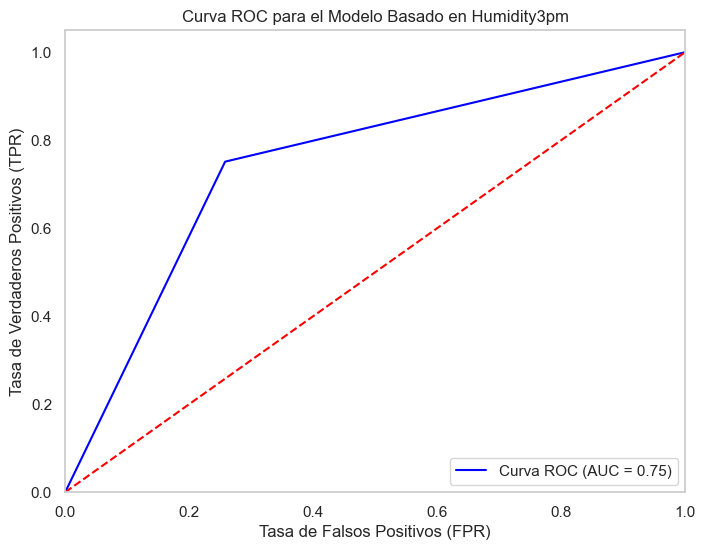

Accuracy del modelo por Humidity: 0.74
AUC del modelo por Humidity: 0.75


In [86]:
# Calcular las probabilidades para la curva ROC
# Asumimos que el valor de umbral para la clase positiva es valor_60_escalado
y_probs_humidity = y_pred_humidity.astype(int)

# Calcular FPR y TPR
fpr_hum, tpr_hum, thresholds_hum = roc_curve(y_test_clean, y_probs_humidity)

# Calcular el AUC
roc_auc_humidity = auc(fpr_hum, tpr_hum)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_hum, tpr_hum, color='blue', label=f'Curva ROC (AUC = {roc_auc_humidity:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Modelo Basado en Humidity3pm')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"Accuracy del modelo por Humidity: {accuracy_humidity:.2f}")
print(f"AUC del modelo por Humidity: {roc_auc_humidity:.2f}")


## Comparación de Modelos

NOTA:

- Precisión (Accuracy): Es la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas.
    - Correctas / Totales

- Recall (Recall o Sensibilidad): Es la proporción de instancias positivas que el modelo predijo correctamente respecto a todas las instancias positivas reales.
    - VP / (VP + FN)

- F1-score: Es la media armónica de precisión y recall. Proporciona una medida única que combina ambos aspectos del rendimiento del modelo.
    - Precisión x Recall / (Precisión + Recall)

- Soporte (Support): Es el número de instancias en el conjunto de datos que pertenecen a cada clase. Ayuda a entender cuán representativas son las muestras de cada clase.

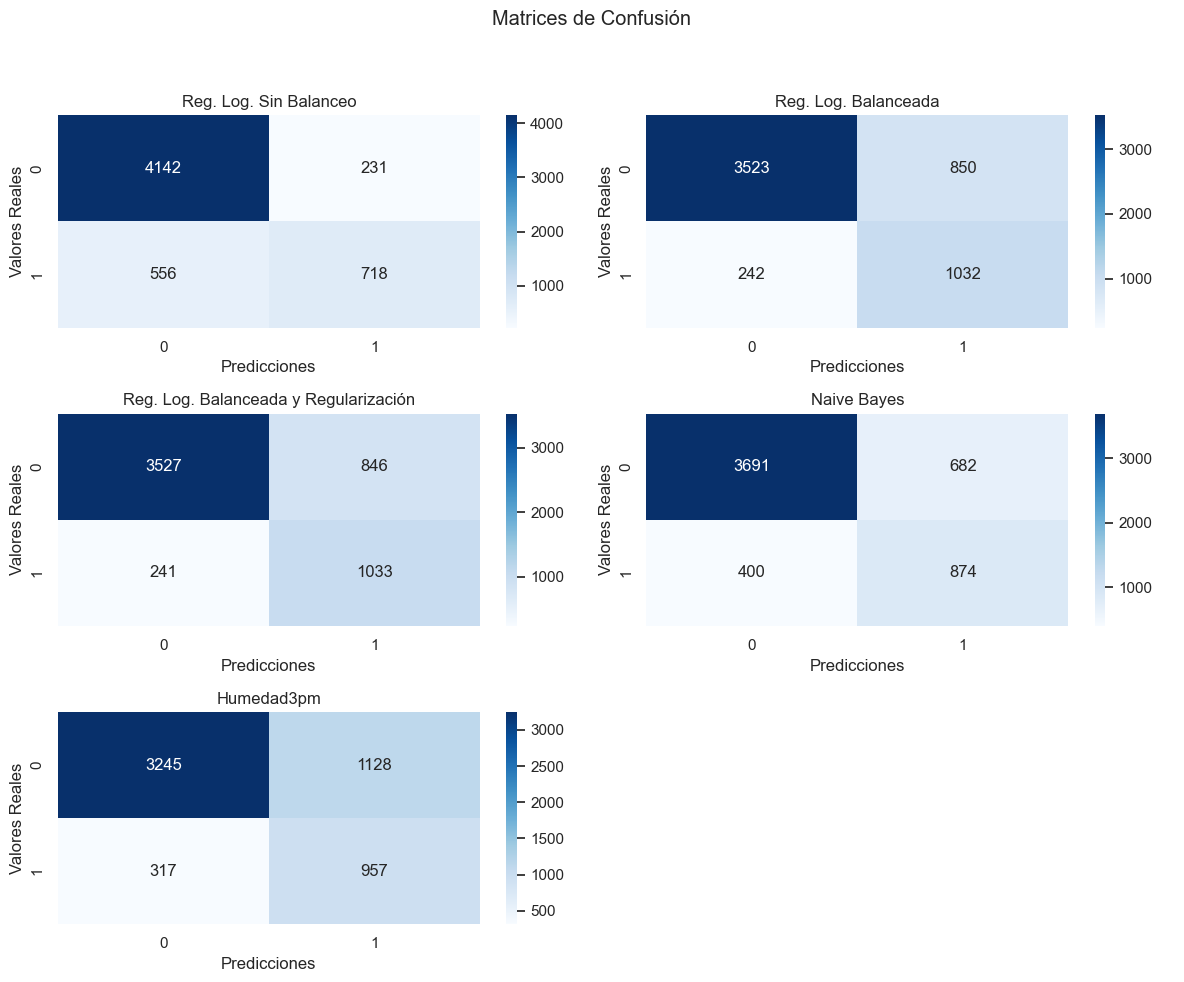

In [87]:
# Crea una figura con cuatro subgráficos
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Título para toda la figura
fig.suptitle("Matrices de Confusión")

# Títulos para cada subgráfico
titles = ["Reg. Log. Sin Balanceo", "Reg. Log. Balanceada", "Reg. Log. Balanceada y Regularización", "Naive Bayes", "Humedad3pm"]

# Matrices de confusión
matrices = [cf_matrix, cf_matrix_b, cf_matrix_reg, cf_matrix_nb, cf_matrix_h ]

for i, ax in enumerate(axes.ravel()):
    if i < len(matrices):  # Verifica que haya matrices disponibles
        sns.heatmap(matrices[i], annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicciones")
        ax.set_ylabel("Valores Reales")
        ax.set_title(titles[i])
    else:
        ax.axis('off')  # Oculta el subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

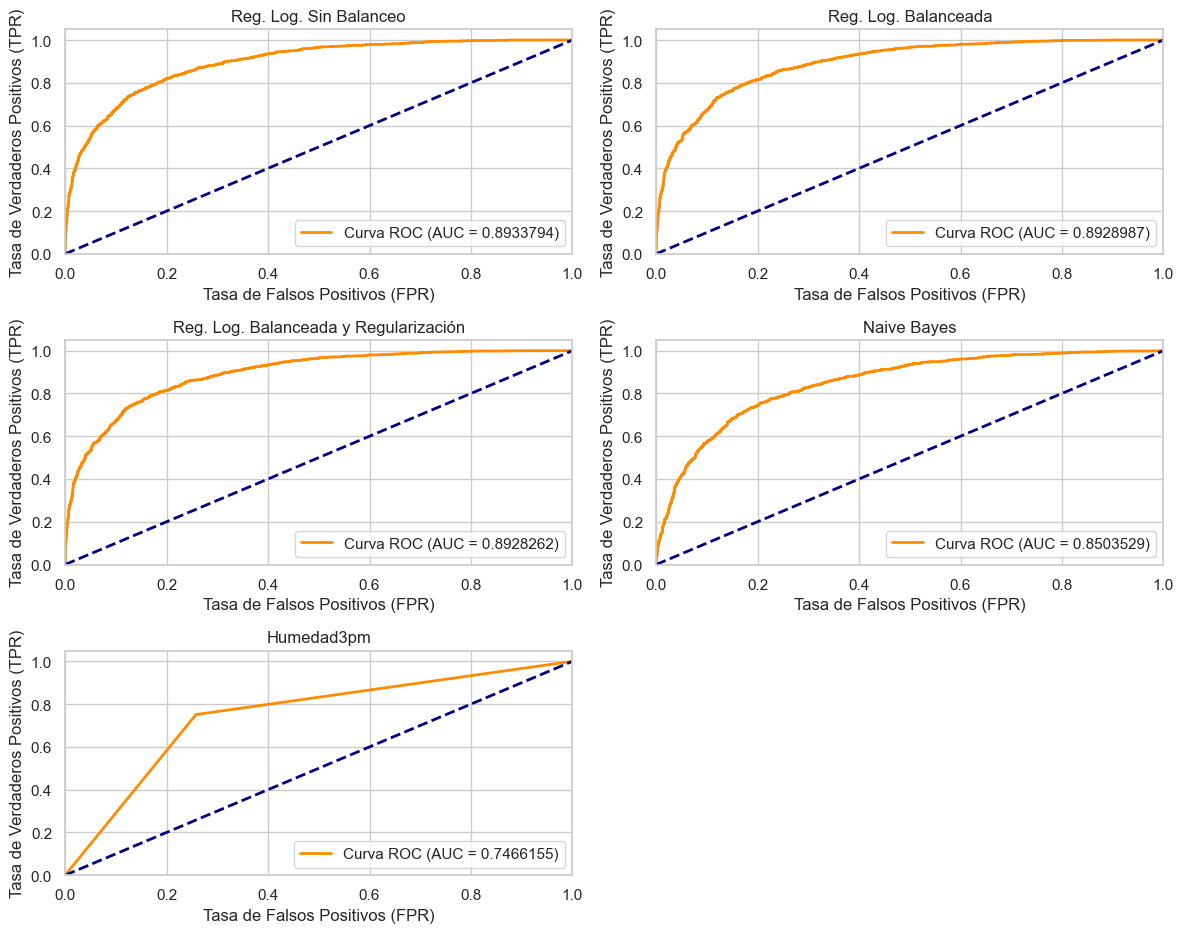

In [88]:
# Crear una figura con cuatro subgráficos
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Títulos para cada subgráfico
titles = ["Reg. Log. Sin Balanceo", "Reg. Log. Balanceada", "Reg. Log. Balanceada y Regularización", "Naive Bayes", "Humedad3pm"]

# Probabilidades y etiquetas de prueba para cada modelo
y_probs_modelos = [y_probs_reglog, y_probs_balanced, y_probs_reg, y_probs_nb, y_probs_humidity]

for i, ax in enumerate(axes.ravel()):
    if i < len(y_probs_modelos):  # Verifica que haya y_probs_modelos disponibles
        fpr, tpr, thresholds = roc_curve(y_test_clean, y_probs_modelos[i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc)
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
        ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        ax.set_title(titles[i])
        ax.legend(loc="lower right")
    else:
        ax.axis('off')  # Oculta el subplot vacío

# Ajusta la disposición de los subgráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [89]:
# Generar los informes de clasificación
report_reglog = classification_report(y_test_clean, y_pred, output_dict=True)
report_balanced = classification_report(y_test_clean, y_pred_balanced, output_dict=True)
report_regularized = classification_report(y_test_clean, y_pred_reg, output_dict=True)
report_base_nb = classification_report(y_test_clean, y_pred_nb, output_dict=True)
report_base_humidity = classification_report(y_test_clean, y_pred_humidity, output_dict=True)

#### Cuadro comparativo métricas.

Realizamos una observación general de todas las métricas.

In [90]:
# Extraer las métricas ( crea del df de métricas )
metrics = {
    "Modelo": [
        "Regresión Logística", 
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada", 
        "Naive Bayes",
        "Modelo Base Humidity"
    ],
    "Accuracy": [
        report_reglog["accuracy"],
        report_balanced["accuracy"],
        report_regularized["accuracy"],
        report_base_nb["accuracy"],
        report_base_humidity["accuracy"]
    ],
    "Precision (Clase 0)": [
        report_reglog["0"]["precision"],
        report_balanced["0"]["precision"],
        report_regularized["0"]["precision"],
        report_base_nb["0"]["precision"],
        report_base_humidity["0"]["precision"]
    ],
    "Precision (Clase 1)": [
        report_reglog["1"]["precision"],
        report_balanced["1"]["precision"],
        report_regularized["1"]["precision"],
        report_base_nb["1"]["precision"],
        report_base_humidity["1"]["precision"]
    ],
    "Recall (Clase 0)": [
        report_reglog["0"]["recall"],
        report_balanced["0"]["recall"],
        report_regularized["0"]["recall"],
        report_base_nb["0"]["recall"],
        report_base_humidity["0"]["recall"]
    ],
    "Recall (Clase 1)": [
        report_reglog["1"]["recall"],
        report_balanced["1"]["recall"],
        report_regularized["1"]["recall"],
        report_base_nb["1"]["recall"],
        report_base_humidity["1"]["recall"]
    ],
    "F1 Score (Clase 0)": [
        report_reglog["0"]["f1-score"],
        report_balanced["0"]["f1-score"],
        report_regularized["0"]["f1-score"],
        report_base_nb["0"]["f1-score"],
        report_base_humidity["0"]["f1-score"]
    ],
    "F1 Score (Clase 1)": [
        report_reglog["1"]["f1-score"],
        report_balanced["1"]["f1-score"],
        report_regularized["1"]["f1-score"],
        report_base_nb["1"]["f1-score"],
        report_base_humidity["1"]["f1-score"]
    ],
    "Balanced Accuracy": [
        balanced_acc_rl, 
        balanced_acc_balanced, 
        balanced_acc_reg, 
        balanced_acc_nv,
        balanced_acc_humidity
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Balanced Accuracy
0,Regresión Logística,0.860634,0.881652,0.756586,0.947176,0.563579,0.913240,0.645974,0.755378
1,Regres. Log. Balanceada,0.806623,0.935724,0.548353,0.805625,0.810047,0.865815,0.653992,0.807836
2,Reg. Log. Balanc. Regularizada,0.807508,0.936040,0.549761,0.806540,0.810832,0.866478,0.655249,0.808686
3,Naive Bayes,0.808394,0.902224,0.561697,0.844043,0.686028,0.872164,0.617668,0.765036
4,Modelo Base Humidity,0.744112,0.911005,0.458993,0.742054,0.751177,0.817895,0.569812,0.746615


Observamos que al Balancear mediante la discriminación de penalidad asignada a cada clase, para evitar que modelo tienda a predecir la categoría mayoritaria, se mejora el recall de la clase minoritaria (Recall 1), pasando de 0.57 a 0.81, que en TP se traduce en 718 a 1032 aciertos. 

In [91]:
# GRÁFICO DE BARRAS DE MÉTRICAS SEPARADAS POR CLASES.
# Usar melt para incluir tanto la clase 0 como la clase 1 (La función melt() transforma el DataFrame para que las métricas estén en una forma "larga" en lugar de "ancha")
metrics_melted = metrics_df.melt(id_vars=["Modelo"], 
                                   value_vars=["Precision (Clase 0)", "Precision (Clase 1)", 
                                               "Recall (Clase 0)", "Recall (Clase 1)", 
                                               "F1 Score (Clase 0)", "F1 Score (Clase 1)"],
                                   var_name="Métrica", 
                                   value_name="Valor")

# Crear el gráfico de barras
fig = px.bar(metrics_melted, 
             x='Modelo', 
             y='Valor', 
             color='Métrica', 
             barmode='group',
             title='Comparativa de Métricas por Modelo y por clases')

fig.show()


#### Umbral óptimo.

Aclaración:
Analizaremos umbral óptimo de los modelos que presentan mejor Balanced Acuraccy y el modelo Base Humidity3pm.

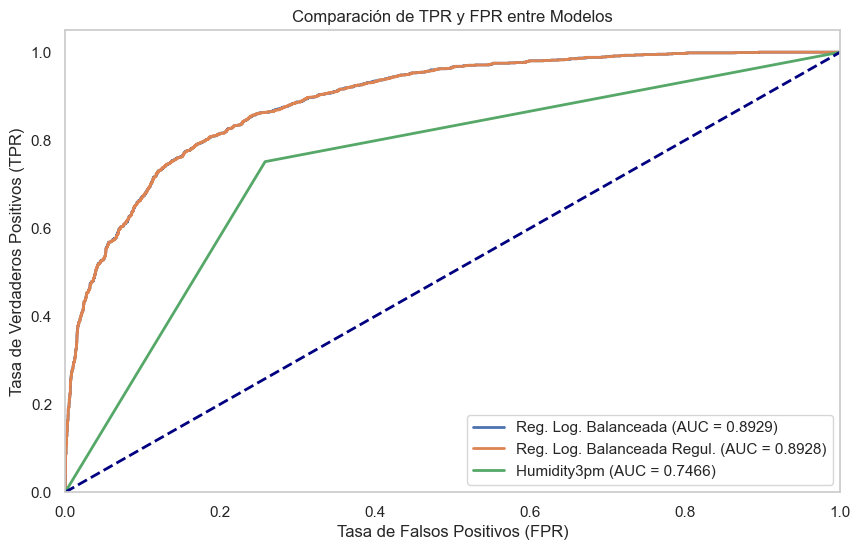

In [92]:
# Relación entre TPR/FPR de Curva ROC y AUC.

# Definir los modelos y sus TPR y FPR
model_names = ["Reg. Log. Balanceada", "Reg. Log. Balanceada Regul.", "Humidity3pm"]
tpr_values = [tpr_ba, tpr_re, tpr_hum]
fpr_values = [fpr_ba, fpr_re, fpr_hum]
y_probs_modelos = [y_probs_balanced, y_probs_reg, y_probs_humidity]  # Probabilidades de cada modelo

# Crear el gráfico
plt.figure(figsize=(10, 6))

for i, model in enumerate(model_names):
    # Calcular AUC para cada modelo
    auc_value = roc_auc_score(y_test_clean, y_probs_modelos[i])
    
    # Graficar TPR vs FPR
    plt.plot(fpr_values[i], tpr_values[i], lw=2, label=f'{model} (AUC = {auc_value:.4f})')

# Agregar líneas de referencia
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal

# Configurar el gráfico
plt.title("Comparación de TPR y FPR entre Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.grid()

# Mostrar el gráfico
plt.show()


Umbral óptimo: Calcular la distancia euclidiana de cada punto de la curva ROC a punto(0,1) o AUC=1.

Nos interesa la distancia mínima: qué tan "cerca" se encuentra de la esquina superior izquierda de la curva ROC, lo que indica un mejor equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.

$\text{distancia} = \sqrt{(\text{FPR})^2 + (1 - \text{TPR})^2}$

Objetivo: Ajustar umbrales para maximizar el Recall 1 y el balanced accuracy.

Pasos: 1) Obtener las Probabilidades de la Clase Positiva

       2) Curva ROC y los Umbrales : función roc_curve para calcular la TPR, FPR y los umbrales para cada modelo.

       3) Encontrar el Umbral Óptimo: 

       4) Hacer Predicciones Usando el Umbral Óptimo
       
       5) Evaluar el Rendimiento: Recall 1 y el Balanced Accuracy para cada modelo utilizando las predicciones ajustadas

NOTA: 

Cálculos ya realizados con antelación por modelo.:

**Predicciones de los distintos modelos:**
y_pred_balanced ,
y_pred_reg ,
y_pred_humidity

**1) Predicciones de Probabilidades**  

Probabilidades de las clases positivas para cada uno de los modelos (método predict_proba):

y_probs_balanced = logistic_model_balanced.predict_proba(x_test_clean)[:, 1]

y_probs_reg = logistic_model_balanced_regul.predict_proba(x_test_clean)[:, 1]

y_probs_humidity

**2) Curva ROC y los Umbrales ( thresholds) : función roc_curve para calcular la TPR, FPR y los umbrales.**

Mejor umbral: 0.5087075228754607
Distancia mínima al punto perfecto: 0.2681946883186379


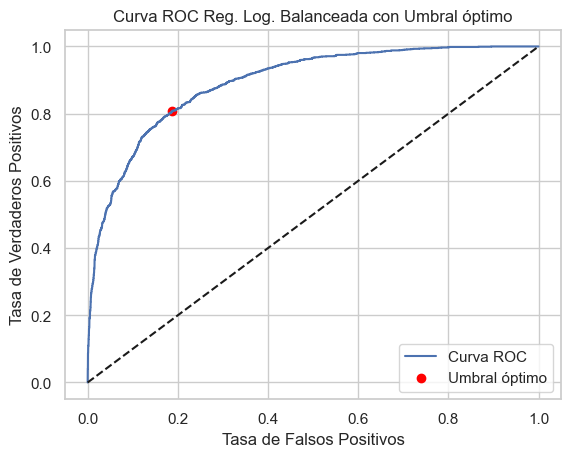

In [93]:
# Observamos Gráficamente Umbral Optimo unicamente para Reg. Logistica Balanceada (distancia a punto (0,1) --> donde AUC = 1)
"""Calcula la curva ROC con las etiquetas verdaderas y las probabilidades de clase positiva.
   Calcula la distancia euclidiana de cada punto de la curva al punto perfecto (0,1).
   Encuentra el umbral que minimiza esta distancia
"""

# Calcular la distancia al punto perfecto
distances = np.sqrt(fpr_ba**2 + (1 - tpr_ba)**2)

# Encontrar el índice del umbral que minimiza la distancia
min_distance_index = np.argmin(distances)
best_threshold = thresholds_ba[min_distance_index]
best_distance = distances[min_distance_index]

print("Mejor umbral:", best_threshold)
print("Distancia mínima al punto perfecto:", best_distance)

import matplotlib.pyplot as plt

plt.plot(fpr_ba, tpr_ba, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.scatter(fpr_ba[min_distance_index], tpr_ba[min_distance_index], color='red', label='Umbral óptimo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Reg. Log. Balanceada con Umbral óptimo')
plt.legend()
plt.show()

In [94]:
# 3) Umbral Óptimo para modelo Balanceado, con Regularizacion y Base " Humidity3pm" y distancia mínima que los determina.
def find_optimal_threshold(fpr, tpr, thresholds):
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)  # Distancia
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    minimum_distance = distances[optimal_idx]
    return optimal_threshold, minimum_distance

# Encontrar umbrales óptimos
optimal_threshold_balanced, min_distance_balanced = find_optimal_threshold(fpr_ba, tpr_ba, thresholds_ba)
optimal_threshold_reg, min_distance_reg = find_optimal_threshold(fpr_re, tpr_re, thresholds_re)
optimal_threshold_hum, min_distance_hum = find_optimal_threshold(fpr_hum, tpr_hum, thresholds_hum)

# Imprimir resultados
print(f'Umbral óptimo (Reg. Log. Balanceada): {optimal_threshold_balanced:.2f}, Distancia mínima: {min_distance_balanced:.4f}')
print(f'Umbral óptimo (Reg. Log. Balanceada Regul.): {optimal_threshold_reg:.2f}, Distancia mínima: {min_distance_reg:.4f}')
print(f'Umbral óptimo (Humidity3pm): {optimal_threshold_hum:.2f}, Distancia mínima: {min_distance_hum:.4f}')


Umbral óptimo (Reg. Log. Balanceada): 0.51, Distancia mínima: 0.2682
Umbral óptimo (Reg. Log. Balanceada Regul.): 0.51, Distancia mínima: 0.2681
Umbral óptimo (Humidity3pm): 1.00, Distancia mínima: 0.3584


In [95]:
# 4) Predicciones finales usando los umbrales óptimos
y_pred_optimal_balanced = (y_probs_balanced >= optimal_threshold_balanced).astype(int)
y_pred_optimal_reg = (y_probs_reg >= optimal_threshold_reg).astype(int)
y_pred_optimal_hum = (y_probs_humidity >= optimal_threshold_hum).astype(int)

In [96]:
# 5) Observación de rendimiento de modelos ajuste de umbral.

# Métricas modelo balanceado optimizado.
f1_balanced = f1_score(y_test_clean, y_pred_optimal_balanced)
balanced_acc_balanced = balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced)
print(f'F1 Score (Reg. Log. Balanceada): {f1_balanced:.4f}, Balanced Accuracy: {balanced_acc_balanced:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_balanced))

# Métricas modelo balanceado y regularización 
f1_reg = f1_score(y_test_clean, y_pred_optimal_reg)
balanced_acc_reg = balanced_accuracy_score(y_test_clean, y_pred_optimal_reg)
print(f'F1 Score (Reg. Log. Balanceada Regul.): {f1_reg:.4f}, Balanced Accuracy: {balanced_acc_reg:.4f}')
print(classification_report(y_test_clean, y_pred_optimal_reg))



F1 Score (Reg. Log. Balanceada): 0.6592, Balanced Accuracy: 0.8104
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.56      0.81      0.66      1274

    accuracy                           0.81      5647
   macro avg       0.75      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647

F1 Score (Reg. Log. Balanceada Regul.): 0.6596, Balanced Accuracy: 0.8104
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4373
           1       0.56      0.81      0.66      1274

    accuracy                           0.81      5647
   macro avg       0.75      0.81      0.76      5647
weighted avg       0.85      0.81      0.82      5647



In [97]:
# 5) Observación de rendimiento general de todas las métricas con ajuste de umbral (métricas con umbral óptimo)
metrics = {
    "Modelo": [
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanc. Regularizada",  
        "Humidity3pm"
    ],
    "Accuracy": [
        accuracy_score(y_test_clean, y_pred_optimal_balanced),
        accuracy_score(y_test_clean, y_pred_optimal_reg),
        accuracy_score(y_test_clean, y_pred_optimal_hum)
    ],
    "Precision (Clase 0)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Precision (Clase 1)": [
        precision_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        precision_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Recall (Clase 0)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "Recall (Clase 1)": [
        recall_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        recall_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "F1 Score (Clase 0)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=0),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=0)
    ],
    "F1 Score (Clase 1)": [
        f1_score(y_test_clean, y_pred_optimal_balanced, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_reg, pos_label=1),
        f1_score(y_test_clean, y_pred_optimal_hum, pos_label=1)
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reg), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Accuracy,Precision (Clase 0),Precision (Clase 1),Recall (Clase 0),Recall (Clase 1),F1 Score (Clase 0),F1 Score (Clase 1),Balanced Accuracy
0,Regres. Log. Balanceada,0.811404,0.935722,0.556456,0.812257,0.808477,0.869629,0.659200,0.810367
1,Reg. Log. Balanc. Regularizada,0.811936,0.935543,0.557421,0.813172,0.807692,0.870076,0.659615,0.810432
2,Humidity3pm,0.744112,0.911005,0.458993,0.742054,0.751177,0.817895,0.569812,0.746615


### Métricas elegidas -con ajuste de Umbral óptimo: Recall 1, Balanced Accuracy-

In [98]:
# Calcular las métricas para cada modelo con el umbral óptimo
metrics = {
    "Modelo": [ 
        "Regres. Log. Balanceada", 
        "Reg. Log. Balanceada y Regularizada", 
        "Humidity3pm"
    ],
    "Recall (Clase 1)": [
        classification_report(y_test_clean, y_pred_optimal_balanced, output_dict=True)["1"]["recall"],
        classification_report(y_test_clean, y_pred_optimal_reg, output_dict=True)["1"]["recall"],
        classification_report(y_test_clean, y_pred_optimal_hum, output_dict=True)["1"]["recall"]
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_test_clean, y_pred_optimal_balanced), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_reg), 
        balanced_accuracy_score(y_test_clean, y_pred_optimal_hum)
    ]
}

# Convertir a DataFrame
metrics_df_umbral = pd.DataFrame(metrics)

# Estilo del DataFrame para mejor visualización
styled_metrics_df = metrics_df_umbral.style.set_table_attributes('style="width: 100%; border-collapse: collapse;"')\
    .set_table_styles([{
        'selector': 'thead th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }, {
        'selector': 'tbody td',
        'props': [('border', '1px solid #ddd'), ('padding', '8px')]
    }])\
    .set_properties(**{'text-align': 'center'})

# Mostrar el DataFrame
styled_metrics_df


,Modelo,Recall (Clase 1),Balanced Accuracy
0,Regres. Log. Balanceada,0.808477,0.810367
1,Reg. Log. Balanceada y Regularizada,0.807692,0.810432
2,Humidity3pm,0.751177,0.746615


## Conclusión Final

En el contexto de los datos proporcionados, nos interesa maximizar el **Recall 1**, que implica maximizar los verdaderos positivos (TP) y minimizar los Falsos Negativos ( error tipo 2). 

 No obsatnte, vamos a observar el comportamiento general del modelo con la métrica **Balanced accuracy**, dado que esta métrica proporciona una evaluación equilibrada del rendimiento del modelo para ambas clases, lo que es crucial en situaciones de desbalance significativo. Nos interesa ver que no estemos sacrificando el rendimiento de la clase mayoritaria en post del incremento del rendimiento de la clase minoritaria.
  (Recordemos que la target que indica "si llueve" (Clase positiva: RainTomorrow = 1) es la minoritaria y "no llueve" (Clase negativa =0), donde "no llueve" es la clase mayoritaria.)
  
  Mediante la aplicacion de tecnicas de balanceo de datos conseguimos mejorar las metricas que consideramos mas importantes.


**Resultado**: El modelo con el cual se obtiene el mejor fitting general es el de Regresión Logística Balanceado y Regularizado.
Este modelo presenta un Recall de la Clase Positiva de 0.807692, y un Balanced Accuracy de 0.810432.

Los modelos superan al modelo Base elegido "Humidity3pm".

## Punto 4: Optimización de selección de Hiperparámetros.

La validación cruzada es una técnica que se utiliza para evaluar la capacidad de generalización de un modelo de machine learning. Al ajustar hiperparámetros en modelos, es importante considerar ciertos parámetros relacionados con la validación cruzada.

<u>Hiperparámetros de validación cruzada</u>:

<u>n_splits</u>: Número de divisiones del conjunto de datos para evaluar el modelo en múltiples pliegues. Ej: Validación cruzada de 5 pliegues (5-fold), los datos se dividen en 5 partes. El modelo se entrena en 4 partes y se evalúa en la 5ª parte

<u>shuffle</u>: Indica si los datos deben mezclarse antes de ser divididos para garantizar representatividad en cada pliegue.

<u>random_state</u>: Semilla que permite reproducir la misma división y barajado de datos en diferentes ejecuciones.

<u>cv</u>: Especifica la **estrategia** de validación cruzada. Puede ser un entero (número de pliegues), un objeto de divisor de validación cruzada (como KFold o StratifiedKFold), o una lista de índices que definen los pliegues. Permite personalizar cómo se dividen los datos.

<u>scoring</u>: Métrica utilizada para evaluar el rendimiento del modelo en cada pliegue, como accuracy o f1.

<u>verbose</u>: Controla el nivel de detalle de la salida durante el proceso de validación cruzada. Controla cuánta información se imprime durante el proceso de validación cruzada. Un valor mayor da más información sobre el progreso.

<u>n_jobs</u>: Número de trabajos a ejecutar en paralelo, donde -1 utiliza todos los núcleos disponibles para acelerar el proceso.

<u>Tres **estrategias** de validación cruzada</u>:

**1) KFold**: Divide el conjunto de datos en 5 partes (o "folds"). En cada iteración, se entrena el modelo con 4 de esos folds y se valida con el fold restante. La opción shuffle=True asegura que los datos se barajen antes de dividirlos, y random_state=42 establece una semilla para la aleatoriedad, asegurando que los resultados sean reproducibles.

**2) StratifiedKFold**: Similar a KFold, pero intenta mantener la misma proporción de clases en cada fold. Esto es útil si tienes un conjunto de datos desbalanceado.

**3) Leave-One-Out**: Una forma extrema de validación cruzada donde para cada muestra en el conjunto de datos, el modelo se entrena con todas las muestras menos una, y se valida con esa única muestra. Esto se repite para cada muestra en el conjunto

<u>Hiperparámetros del modelo a ajustar utilizando validación cruzada, para encontrar la mejor combinación y mejorar el rendimiento:</u>

**n_splits:** Número de divisiones en las que se divide el conjunto de datos. Por ejemplo, en una validación cruzada de 5 pliegues (5-fold), los datos se dividen en 5 partes. El modelo se entrena en 4 partes y se evalúa en la 5ª parte

**C:** hiperparámetro de regularización que controla la penalización de errores en la clasificación. Valores más altos de C pueden llevar a un modelo más complejo (menor regularización), mientras que valores más bajos hacen que el modelo sea más simple (mayor regularización).

        Escala Logarítmica: Usar np.logspace(-5, 5, num=100) genera 100 valores entre 10(−5)  y 10(5) , lo que permite explorar un rango amplio de valores.

**penalty:** Tipo de penalización que se aplica al modelo.

        'l1': Regularización Lasso, que puede llevar a que algunos coeficientes sean cero.

        'l2': Regularización Ridge, que penaliza el tamaño de los coeficientes.

        'elasticnet': Combina ambos tipos de regularización

**max_iter**: Número máximo de iteraciones para el optimizador.

        Rango: range(100, 1001) indica que se probarán valores entre 100 y 1000 (incluyendo 1000).

        Uso: Un número mayor de iteraciones permite que el modelo converja mejor, pero también incrementa el tiempo de computación.


**class_weight**: Manejo del balance de clases, especialmente útil en conjuntos de datos desbalanceados.

        'balanced': Ajusta los pesos inversamente proporcionales a las frecuencias de las clases.

        None: No aplica pesos.

Definimos el espacio de búsqueda de hiperparámetros, para la optimización de los mismos.

In [160]:
# Definir el espacio de hiperparámetros
param_grid = {
    'C': np.logspace(-5, 5, num=100),  # Valores de C en escala logarítmica
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': range(100, 1001),  # 1000 es el valor máximo incluido
    'class_weight': ['balanced', None]
}

In [161]:
#Planteamos las distintas estrategias de valudación cruzada, pero solo utilizamos KFolds.
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    #("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42)),
    #("Leave-One-Out", LeaveOneOut()),
]


### K-FOLD

NOTA: Recordar que nuestros datos ya estaban escalados **NO SE ESCALAN VARIABLES CUALITATIVAS**

scaler = StandardScaler()

X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)

X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)

**Luego eliminamos la columna 'Date' de los conjuntos ( nos quedamos con los meses)**

x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])

**No es necesario modificar y_train y y_test**

y_train_clean = y_train_encoded

y_test_clean = y_test_encoded

In [162]:
# Definir el modelo clasificador de regresión logística
clf = LogisticRegression()   # clf como una instancia de LogisticRegression (modelo = LogisticRegression() )
"""
# scaler = StandardScaler()               # Los datos ya estan esclados.
# X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
# X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)
# x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
# x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
# y_train_clean = y_train_encoded
# y_test_clean = y_test_encoded     
"""

"\n# scaler = StandardScaler()               # Los datos ya estan esclados.\n# X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)\n# X_test_encoded_imputed_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)\n# x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])\n# x_test_clean = X_test_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])\n# y_train_clean = y_train_encoded\n# y_test_clean = y_test_encoded     \n"

In [163]:
# Solución si se quiere evaluar más de una estrategia de Validación cruzada.
results = {}                   # inicializa un diccionario results para almacenar los resultados.
for name, cv in cv_strategies: # se itera sobre cada estrategia de validación cruzada. Por cada par de nombre y objeto de validación cruzada (name, cv):
    scores = cross_val_score(clf, x_train_clean, y_train_clean, cv=cv) # cross_val_score evalúa (accuracy por default) el modelo clf  con la estrategia de validación cruzada especificada por cv.
    results[name] = scores     # cross_val_score devuelve un array de puntuaciones obtenidas en cada una de las divisiones Y esos scores se almacenan en el diccionario results bajo la clave correspondiente al nombre de la estrategia.


Este código está diseñado para comparar diferentes estrategias de validación cruzada y evaluar el rendimiento de un modelo (clf) sobre un conjunto de datos (x_train_clean, y_train_clean), almacenando las puntuaciones obtenidas para cada estrategia. Esto te permite ver cuál método de validación proporciona mejores resultados para tu modelo. Por defecto, cross_val_score utiliza la métrica de **accuracy** para clasificación.

In [164]:
# Accuracys con Validación Cruzda obtenidos:
results['KFold']

array([0.85662939, 0.86056732, 0.86256492, 0.85457451, 0.86176588])

In [165]:
for name in results:
    print('Media de accuracy para la estrategia', name, ':', results[name].mean())
    print('Desvío estándar para la estrategia', name, ':', results[name].std())


Media de accuracy para la estrategia KFold : 0.8592204051623675
Desvío estándar para la estrategia KFold : 0.0030911841905424376


In [166]:
# Imprto libreria para que muestres los resultados de la variables automaticamente en Markdown.
from IPython.display import display, Markdown
mean_accuracy=  results[name].mean()
mean_desvio_standard= results[name].std()

In [167]:
# Función para mostrar los resultados de K-Fold.
def show_results_k_fold(mean_accuracy, mean_desvio_standard):
    display(Markdown(f"Media para la estrategia KFold: **{mean_accuracy:.4f}**\n\n"
                     f"Este valor representa la **exactitud-accuracy- promedio** del modelo cuando se evalúa utilizando la estrategia KFold. "
                     f"En este caso, el modelo tiene un rendimiento promedio de aproximadamente **{mean_accuracy * 100:.2f}%**. "
                     f"Esto indica que, en promedio, el modelo predice correctamente el **{mean_accuracy * 100:.2f}%** de las instancias en los datos de prueba a lo largo de todas las divisiones de KFold."))
    display(Markdown(f"Desvío estándar para la estrategia KFold: **{mean_desvio_standard:.4f}**\n\n"
                     f"Este valor refleja la variabilidad o consistencia del rendimiento del modelo entre las diferentes particiones de los datos. "
                     f"Un desvío estándar bajo, como **{mean_desvio_standard:.4f}**, sugiere que las puntuaciones del modelo son bastante consistentes. "
                     f"El modelo no solo tiene un buen rendimiento promedio, sino que también tiene un rendimiento similar en todas las divisiones de los datos, "
                     f"lo que indica que no está sobreajustando a un conjunto específico."))
    



In [168]:
# Llamo a la función
show_results_k_fold(mean_accuracy, mean_desvio_standard)

Media para la estrategia KFold: **0.8592**

Este valor representa la **exactitud-accuracy- promedio** del modelo cuando se evalúa utilizando la estrategia KFold. En este caso, el modelo tiene un rendimiento promedio de aproximadamente **85.92%**. Esto indica que, en promedio, el modelo predice correctamente el **85.92%** de las instancias en los datos de prueba a lo largo de todas las divisiones de KFold.

Desvío estándar para la estrategia KFold: **0.0031**

Este valor refleja la variabilidad o consistencia del rendimiento del modelo entre las diferentes particiones de los datos. Un desvío estándar bajo, como **0.0031**, sugiere que las puntuaciones del modelo son bastante consistentes. El modelo no solo tiene un buen rendimiento promedio, sino que también tiene un rendimiento similar en todas las divisiones de los datos, lo que indica que no está sobreajustando a un conjunto específico.

Rendimiento General: Una media alta, sugiere que el modelo es eficaz para hacer predicciones.

Robustez: Un desvío estándar bajo indica que el modelo tiene un rendimiento confiable y que es menos probable que se vea afectado por la variabilidad en los datos. Esto es importante, ya que un modelo que tiene un buen rendimiento en un conjunto de datos pero un rendimiento inconsistente en otros podría no ser útil en la práctica.

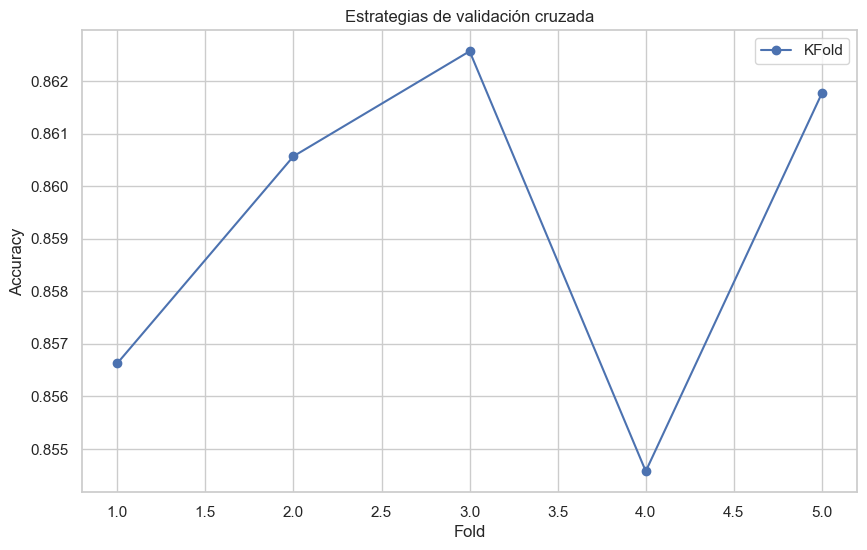

In [169]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()


### GridSearch

In [116]:
# Debemos dividir X_train y y_train para crear un conjunto de validación: No hay fuga de datos al dividir después de haber preprocesado.
# Aplicar el mismo escalado y codificación a x_val que aplicamos a x_train_clean.
x_train_clean, x_val, y_train_clean, y_val = train_test_split(x_train_clean, y_train_clean, test_size=0.25, random_state=42)  # 0.25 de 0.8 es 0.2 del total

# Pre-procesameinto aplicado a conj. de entrenamiento aplicar a conj. de Validación: cualquier transformación aplicada a x_train se aplica de la misma manera a x_val. Esto es crucial para mantener la integridad de los modelos.
# Aquí puedes aplicar el escalado y la codificación a X_train y X_val
# scaler = StandardScaler()
# X_train_encoded_imputed_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
# x_train_clean = X_train_encoded_imputed_cuantiscaled_cuali.drop(columns=['Date'])
x_val_scaled = scaler.transform(x_val)
x_val_clean = x_val_scaled

x_train_clean y y_train_clean --> para ajustar el modelo.

x_val_clean y y_val_clean --> para evaluar el rendimiento durante la búsqueda de hiperparámetros.

In [ ]:
# from sklearn.metrics import make_scorer, f1_score

In [118]:
# Utilizamos GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring={
        'recall': 'recall',                 # Recall para la clase positiva (1)
        'balanced_accuracy': 'balanced_accuracy'  # Balanced accuracy
    },
    refit='recall',                         # Se ajusta de nuevo usando la métrica seleccionada
    cv=5,                                   # Validación cruzada con 5 folds
    n_jobs=-1                               # Usar todos los núcleos disponibles
)


# Reducimos el tamaño del conjunto de datos para la búsqueda de hiperparámetros (usamos solo el 30% de los datos)
# si dejo el 30% de los datos, tarda 78 minutos y 51.6seg y determina = {'C': 0.03430469, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}
X_sample = x_val.sample(frac=0.3, random_state=42)
y_sample = y_val.loc[X_sample.index]

# # Ajustar el modelo con la muestra reducida
grid_search.fit(X_sample, y_sample)


# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'C': np.float64(0.03430469286314919), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}


In [119]:
trials_grid = grid_search.cv_results_
plot_params_trials(trials_grid, 'Grid')

NameError: name 'plot_params_trials' is not defined

## Punto 5: Explicabilidad -SHARP-

## Punto 6 : Implementar Modelo de AUTO-ML con scikit-learn

In [105]:
"""
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(x_train_clean, y_train_clean)
predictions = cls.predict(X_test)
"""

'\nimport autosklearn.classification\ncls = autosklearn.classification.AutoSklearnClassifier()\ncls.fit(x_train_clean, y_train_clean)\npredictions = cls.predict(X_test)\n'

TPOT y Auto-sklearn son dos bibliotecas diferentes para AutoML, aunque ambas están diseñadas para automatizar el proceso de selección y optimización de modelos de machine learning.

Diferencias clave:

TPOT:

Se basa en algoritmos evolutivos para optimizar pipelines de machine learning.
Usa un enfoque de programación genética para encontrar la mejor combinación de preprocesamiento y modelos.
Es especialmente conocido por su capacidad de generar código Python que representa el pipeline óptimo encontrado.

Auto-sklearn:

Se basa en la biblioteca scikit-learn y utiliza técnicas de optimización bayesiana para seleccionar modelos y ajustar hiperparámetros.
Proporciona un enfoque más tradicional para el AutoML, centrándose en modelos de scikit-learn.
Ambas bibliotecas tienen sus fortalezas y pueden ser utilizadas dependiendo de las necesidades específicas de tu proyecto. Si buscas un enfoque basado en algoritmos evolutivos, elige TPOT; si prefieres un enfoque más convencional de optimización bayesiana, Auto-sklearn podría ser más adecuado. 

In [108]:
# Importar librerías
from tpot import TPOTClassifier

In [109]:
""" PRUEBA 2

# RECALL 1 Y BALANCED ACCURACY

# SOLICITE MENOS TIEMPO:
Cambios Realizados:
Hiperparámetros:

Generaciones: Reducido a 3 para un entrenamiento más corto.

Tamaño de población: Reducido a 10 para disminuir la carga computacional.

Configuración: Se agregó config_dict='TPOT sparse' para utilizar una configuración más ligera que busca modelos más simples y rápidos.
"""

# Crear y ajustar el modelo TPOT con parámetros ajustados para un entrenamiento más corto
tpot = TPOTClassifier(verbosity=2, generations=3, population_size=10, random_state=42, 
                      config_dict='TPOT sparse')  # Usar una configuración más ligera

# Ajustar el modelo
tpot.fit(x_train_clean, y_train_clean)

# Hacer predicciones
predictions = tpot.predict(x_test_clean)

# Calcular Balanced Accuracy y Recall
balanced_accuracy = balanced_accuracy_score(y_test_clean, predictions)
recall = recall_score(y_test_clean, predictions, average='binary')  # Cambia 'binary' según tu problema

# Imprimir resultados
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Recall: {recall}")

                                                                            
Generation 1 - Current best internal CV score: 0.8682876263129862
                                                                            
Generation 2 - Current best internal CV score: 0.8709837203607824
                                                                            
Generation 3 - Current best internal CV score: 0.8709837203607824
                                                                            
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.4, verbosity=0)
Balanced Accuracy: 0.7735329826489867
Recall: 0.6067503924646782
